# Purpose

In notebook 09 I combined embeddings from posts & subreddits (`djb_09.00-combine_post_and_comments_and_visualize_for_presentation.ipynb`).

In this notebook I'll be testing functions that include mlflow so that it's easier to try a lot of different weights to find better respresentations.

Take embeddings created by other models & combine them:
```
new post embeddings = post + comments + subreddit description

new subreddit embeddings = new posts (weighted by post length or upvotes?)
```

# Notebook setup

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from datetime import datetime
import gc
import os
import logging

import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import seaborn as sns

import dask
from dask import dataframe as dd
from tqdm.auto import tqdm

import mlflow

import subclu
from subclu.models.aggregate_embeddings import (
    AggregateEmbeddings
)

from subclu.utils import set_working_directory
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric
)
from subclu.utils.mlflow_logger import MlflowLogger, save_pd_df_to_parquet_in_chunks
from subclu.eda.aggregates import (
    compare_raw_v_weighted_language
)
from subclu.utils.data_irl_style import (
    get_colormap, theme_dirl
)


print_lib_versions([dask, np, pd, plotly, sns, subclu])

python		v 3.7.10
===
dask		v: 2021.06.0
numpy		v: 1.18.5
pandas		v: 1.2.4
plotly		v: 4.14.3
seaborn		v: 0.11.1
subclu		v: 0.3.1


In [3]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
plt.style.use('default')

setup_logging()
notebook_display_config()

# Set sqlite database as MLflow URI

In [4]:
# use new class to initialize mlflow
mlf = MlflowLogger(tracking_uri='sqlite')
mlflow.get_tracking_uri()

'sqlite:////home/jupyter/mlflow/mlruns.db'

## Get list of experiments with new function

In [5]:
mlf.list_experiment_meta(output_format='pandas')

,experiment_id,name,artifact_location,lifecycle_stage
0,0,Default,./mlruns/0,active
1,1,fse_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/1,active
2,2,fse_vectorize_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/2,active
3,3,subreddit_description_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/3,active
4,4,fse_vectorize_v1.1,gs://i18n-subreddit-clustering/mlflow/mlruns/4,active
5,5,use_multilingual_v0.1_test,gs://i18n-subreddit-clustering/mlflow/mlruns/5,active
6,6,use_multilingual_v1,gs://i18n-subreddit-clustering/mlflow/mlruns/6,active
7,7,use_multilingual_v1_aggregates_test,gs://i18n-subreddit-clustering/mlflow/mlruns/7,active
8,8,use_multilingual_v1_aggregates,gs://i18n-subreddit-clustering/mlflow/mlruns/8,active


In [ ]:
BREAK

# Kick off sample job to load vectors & metadata

Move to using a class instead of a function because it's easier to make it modular.

Loading the vectors/embeddings & metadat can take ~2 minutes each run.
So we're loading the data only once so that it's faster to test/iterate on different parameters.

In [9]:
%%time

mlflow.end_run("KILLED")

job_agg = AggregateEmbeddings(
    bucket_name='i18n-subreddit-clustering',
    folder_meta_subreddits='subreddits/de/2021-06-16',
    folder_meta_comments='comments/de/2021-06-16',
    folder_meta_posts='posts/de/2021-06-16',
    
    posts_uuid='db7a4d8aff04420eb4229d6499055e04',
    posts_folder='df_vect_posts',
    col_text_post_word_count='text_word_count',
    col_post_id='post_id',

    comments_uuid='db7a4d8aff04420eb4229d6499055e04',
    comments_folder='df_vect_comments',
    col_comment_id='comment_id',
    col_text_comment_word_count='comment_text_word_count',
    min_comment_text_len=11,

    subreddit_desc_uuid='db7a4d8aff04420eb4229d6499055e04',
    subreddit_desc_folder='df_vect_subreddits_description',
    col_subreddit_id='subreddit_id',

    mlflow_experiment='use_multilingual_v1_aggregates_test',
    run_name=f"test_base{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    mlflow_tracking_uri='sqlite',

    n_sample_posts=None,
    n_sample_comments=None,
    
    # weights for weighted averages
    agg_comments_to_post_weight_col='comment_text_len',
    agg_post_to_subreddit_weight_col=None,
    agg_post_post_weight=70,
    agg_post_comment_weight=20,
    agg_post_subreddit_desc_weight=10,
    
)

job_agg._load_raw_embeddings()
job_agg._load_metadata()

d_dfs = dict()
(
    d_dfs['df_v_sub'], d_dfs['df_v_posts'], d_dfs['df_v_comments'],
    d_dfs['df_subs_meta'], d_dfs['df_posts_meta'], d_dfs['df_comments_meta'],
    
) = (
    job_agg.df_v_sub, job_agg.df_v_posts, job_agg.df_v_comments,
    job_agg.df_subs_meta, job_agg.df_posts_meta, job_agg.df_comments_meta,
)

20:24:03 | INFO | "-- Start _load_raw_embeddings() method --"
20:24:03 | INFO | "Loading subreddit description embeddings..."
20:24:05 | INFO | "  (629, 512) <- Raw vectorized subreddit description shape"
20:24:05 | INFO | "Loading POSTS embeddings..."
20:25:01 | INFO | "  (262226, 512) <- Raw POSTS shape"
20:25:02 | INFO | "Loading COMMENTS embeddings..."
20:27:53 | INFO | "  (1108757, 512) <- Raw COMMENTS shape"
20:27:53 | INFO | "  Keep only comments for posts with embeddings"
20:27:54 | INFO | "  (1108757, 512) <- COMMENTS shape, after keeping only existing posts"
20:27:55 | INFO | "  0:03:52.240985 <- Total raw embeddings load time elapsed"
20:27:56 | INFO | "-- Start _load_metadata() method --"
20:27:56 | INFO | "Loading POSTS metadata..."
20:27:56 | INFO | "Reading raw data..."
20:28:25 | INFO | "  Applying transformations..."
20:28:25 | INFO | "  (262226, 14) <- Raw META POSTS shape"
20:28:25 | INFO | "Loading subs metadata..."
20:28:25 | INFO | "  reading sub-level data & merg

CPU times: user 44.1 s, sys: 11.8 s, total: 55.9 s
Wall time: 5min


## Check shape & memory usage for main dfs

In [10]:
for k, df_ in d_dfs.items():
    print(f"\n{k}")
    try:
        print(f"{df_.shape} <- df shape")
        if 'meta' in k:
            print(f"  {df_.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
            # df_.info(memory_usage='deep')
        else:
            df_.info(memory_usage='deep')
            print(f"  {df_.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
            # display(df_.iloc[:5, :15])
    except AttributeError:
        pass


df_v_sub
(629, 512) <- df shape
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 629 entries, ('de', 't5_22i0') to ('gamingde', 't5_wv77f')
Columns: 512 entries, embeddings_0 to embeddings_511
dtypes: float32(512)
memory usage: 1.3 MB
   1.3 MB <- Memory usage

df_v_posts
(262226, 512) <- df shape
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 262226 entries, ('deutschetributes', 't5_3nl4m8', 't3_n26p3d') to ('wixbros', 't5_3kytod', 't3_nw9zc1')
Columns: 512 entries, embeddings_0 to embeddings_511
dtypes: float32(512)
memory usage: 538.8 MB
  538.8 MB <- Memory usage

df_v_comments
(1108757, 512) <- df shape
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1108757 entries, ('nicoledobrikov1', 't5_3oioc0', 't3_mhygq9', 't1_gyfm5oo') to ('askagerman', 't5_2y3st', 't3_msfh1i', 't1_gus8zkj')
Columns: 512 entries, embeddings_0 to embeddings_511
dtypes: float32(512)
memory usage: 2.2 GB
  2,293.6 MB <- Memory usage

df_subs_meta
(629, 43) <- df shape
   1.5 MB <- Memory usage

df_posts

# Use pre-loaded embeddings to speed up iterations

Save around 2 to ~4 minutes when loading embeddings from a single file

TODO(djb): when saving embeddings save them in multiple files so that arrow can load them in parallel

In [9]:
print(110 // 40)
print(210 // 40)
print(540 // 40)
print(1010 // 40)
print(2040 // 40)

2
5
13
25
51


In [27]:
# try:
#     del d_dfs2, job_agg2
# except NameError:
#     pass
# gc.collect()

In [82]:
%%time

mlflow.end_run("KILLED")

try:
    del d_dfs2, job_agg2
except NameError:
    pass
gc.collect()

job_agg2 = AggregateEmbeddings(
    bucket_name='i18n-subreddit-clustering',
    folder_meta_subreddits='subreddits/de/2021-06-16',
    folder_meta_comments='comments/de/2021-06-16',
    folder_meta_posts='posts/de/2021-06-16',
    
    posts_uuid='db7a4d8aff04420eb4229d6499055e04',
    posts_folder='df_vect_posts',
    col_text_post_word_count='text_word_count',
    col_post_id='post_id',

    comments_uuid='db7a4d8aff04420eb4229d6499055e04',
    comments_folder='df_vect_comments',
    col_comment_id='comment_id',
    col_text_comment_word_count='comment_text_word_count',
    min_comment_text_len=11,

    subreddit_desc_uuid='db7a4d8aff04420eb4229d6499055e04',
    subreddit_desc_folder='df_vect_subreddits_description',
    col_subreddit_id='subreddit_id',

    mlflow_experiment='use_multilingual_v1_aggregates_test',
    run_name=f"test_base{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    mlflow_tracking_uri='sqlite',

    n_sample_posts=10000,
    n_sample_comments=40000,
    
    # weights for weighted averages
    agg_comments_to_post_weight_col='comment_text_len',
    agg_post_to_subreddit_weight_col=None,
    agg_post_post_weight=70,
    agg_post_comment_weight=20,
    agg_post_subreddit_desc_weight=10,
    
    # preloaded embeddings:
    df_v_sub=d_dfs['df_v_sub'],
    df_v_posts=d_dfs['df_v_posts'],
    df_v_comments=d_dfs['df_v_comments'],
    
    # preloaded metadata:
    df_subs_meta=d_dfs['df_subs_meta'],
    df_posts_meta=d_dfs['df_posts_meta'],
    df_comments_meta=d_dfs['df_comments_meta'],
)

d_dfs2 = dict()
(
    # Aggs don't get computed until run_aggergation() method gets called
    d_dfs2['df_subs_agg_a'], d_dfs2['df_subs_agg_b'], d_dfs2['df_subs_agg_c'], 
    d_dfs2['df_posts_agg_b'], d_dfs2['df_posts_agg_c'], d_dfs2['df_posts_agg_d']

) = job_agg2.run_aggregation()

(
    d_dfs2['df_v_sub'], d_dfs2['df_v_posts'], d_dfs2['df_v_comments'],
#     d_dfs2['df_subs_meta'], d_dfs2['df_posts_meta'], d_dfs2['df_comments_meta']
    
) = (
    job_agg2.df_v_sub, job_agg2.df_v_posts, job_agg2.df_v_comments,
#     job_agg2.df_subs_meta, job_agg2.df_posts_meta, job_agg2.df_comments_meta
)
gc.collect()

22:47:32 | INFO | "== Start run_aggregation() method =="
22:47:32 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/mlflow/mlruns.db"
22:47:32 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-07-13_224732-test_base2021-07-13_224731"
22:47:32 | INFO | "  Saving config to local path..."
22:47:32 | INFO | "  Logging config to mlflow..."
22:47:34 | INFO | "-- Start _load_raw_embeddings() method --"
22:47:34 | INFO | "Raw subreddit embeddings pre-loaded"
22:47:34 | INFO | "  (629, 512) <- Raw vectorized subreddit description shape"
22:47:34 | INFO | "POSTS embeddings pre-loaded"
22:47:34 | INFO | "  (262226, 512) <- Raw POSTS shape"
22:47:34 | INFO | "  Sampling POSTS down to: 10,000"
22:47:34 | INFO | "  (10000, 512) <- df_posts.shape AFTER sampling"
22:47:35 | INFO | "COMMENTS embeddings pre-loaded"
22:47:36 | INFO | "  (1108757, 512) <- Raw COMMENTS shape"
22:47:36 | INFO | "  Keep only comments for posts with em

  0%|          | 0/3108 [00:00<?, ?it/s]

22:48:07 | INFO | "  (3108, 512) <- df_agg_multi_comments shape, weighted avg only"
22:48:07 | INFO | "  (1271, 512) <- df_v_comments shape for comments that DO NOT need to be aggregated"
22:48:07 | INFO | "  (4379, 512) <- df_v_com_agg shape after aggregation"
22:48:07 | INFO | "  0:00:28.106195 <- Total comments to post agg loading time elapsed"
22:48:07 | INFO | "-- Start _agg_posts_and_comments_to_post_level() method --"
22:48:07 | INFO | "      4,379 <- Posts that need weighted average"


  0%|          | 0/4379 [00:00<?, ?it/s]

22:48:15 | INFO | "  (4379, 512) <- df_agg_posts_w_comments.shape (only posts with comments)"
22:48:16 | INFO | "  (10000, 512) <- df_posts_agg_b shape after aggregation"
22:48:16 | INFO | "  0:00:08.597862 <- Total posts & comments agg time elapsed"
22:48:16 | INFO | "-- Start _agg_posts_and_comments_to_post_level() method --"


  0%|          | 0/10000 [00:00<?, ?it/s]

22:48:34 | INFO | "  (10000, 512) <- df_agg_posts_w_sub.shape (only posts with comments)"
22:48:34 | INFO | "  (10000, 512) <- df_posts_agg_c shape after aggregation"
22:48:34 | INFO | "  0:00:18.646059 <- Total posts+comments+subs agg time elapsed"
22:48:34 | INFO | "-- Start _agg_posts_and_comments_to_post_level() method --"
22:48:34 | INFO | "No column to weight comments, simple mean to roll up posts to subreddit-level..."
22:48:34 | INFO | "A - posts only"
22:48:34 | INFO | "  (516, 512) <- df_subs_agg_a.shape (only posts)"
22:48:34 | INFO | "B - posts + comments"
22:48:34 | INFO | "  (516, 512) <- df_subs_agg_b.shape (posts + comments)"
22:48:34 | INFO | "C - posts + comments + sub descriptions"
22:48:34 | INFO | "  (516, 512) <- df_subs_agg_c.shape (posts + comments + sub description)"
22:48:34 | INFO | "  0:00:00.192255 <- Total for all subreddit-level agg time elapsed"
22:48:34 | INFO | "-- Start _calculate_subreddit_similarities() method --"
22:48:34 | INFO | "A..."
22:48:34 |

  0%|          | 0/11 [00:00<?, ?it/s]

22:48:40 | INFO | "** df_post_level_agg_b_post_and_comments **"
22:48:40 | INFO | "Saving locally..."
22:48:40 | INFO | "    41.0 MB <- Memory usage"
22:48:40 | INFO | "     2.0 <- target Dask partitions	   30.0 <- target MB partition size"
22:48:41 | INFO | "Logging artifact to mlflow..."
22:48:45 | INFO | "** df_post_level_agg_c_post_comments_sub_desc **"
22:48:45 | INFO | "Saving locally..."
22:48:45 | INFO | "    41.0 MB <- Memory usage"
22:48:45 | INFO | "     2.0 <- target Dask partitions	   30.0 <- target MB partition size"
22:48:45 | INFO | "Logging artifact to mlflow..."
22:48:48 | INFO | "** df_sub_level_agg_a_post_only **"
22:48:48 | INFO | "Saving locally..."
22:48:48 | INFO | "     1.1 MB <- Memory usage"
22:48:48 | INFO | "     1.0 <- target Dask partitions	   30.0 <- target MB partition size"
22:48:48 | INFO | "Logging artifact to mlflow..."
22:48:53 | INFO | "** df_sub_level_agg_a_post_only_similarity **"
22:48:53 | INFO | "Saving locally..."
22:48:53 | INFO | "Keeping 

CPU times: user 1min 12s, sys: 12.1 s, total: 1min 25s
Wall time: 1min 35s


10000

In [83]:
for k2, df_2 in d_dfs2.items():       
    print(f"\n{k2}")
    try:
        print(f"{df_2.shape} <- df shape")
        if any(['meta' in k2, '_v_' in k2]):
            print(f"  {df_2.memory_usage(deep=True).sum() / 1048576:4,.1f} MB <- Memory usage")
        else:
            pass
            # display(df_2.iloc[:5, :15])

    except AttributeError:
        pass


df_subs_agg_a
(516, 512) <- df shape

df_subs_agg_b
(516, 512) <- df shape

df_subs_agg_c
(516, 512) <- df shape

df_posts_agg_b
(10000, 512) <- df shape

df_posts_agg_c
(10000, 512) <- df shape

df_posts_agg_d

df_v_sub
(629, 512) <- df shape
   1.3 MB <- Memory usage

df_v_posts
(10000, 512) <- df shape
  44.3 MB <- Memory usage

df_v_comments
(36069, 512) <- df shape
  186.2 MB <- Memory usage


In [46]:
# print(job_agg2.df_subs_agg_a_similarity.shape)
# job_agg2.df_subs_agg_a_similarity.iloc[:5, :10]

## Check top subs for similarities

In [55]:
job_agg2.df_subs_agg_a_similarity.head()

subreddit_name,1fcnuernberg,600euro,aachen,aeiou,afd,afdkritisiertafd,afdwatch,aktien,alexisshv,alinamour_hot,alinejost,almancis,ameisenstrassenwetten,anastasijalukic,annaschmidt,annaschmidtihot,anne_wuensche,annemarie_carpendale,annitheduck,annitheporn,annode,annyaurora,ansgar,antoniasainz,aoede,apexlegendsde,arbeitsleben,asiatischkochen,askagerman,askswitzerland,...,vegetarischde,vegetarischkochen,veronapooth,vfbstuttgart,victorialukac,vivianegeppert,volksverpetzer,wasletztepreis,weibsvolk,whosrobin,wien,wirklichgutefrage,wissenschaft,witze,wixbros,wortwitzkasse,wuppertal,xboxde,yoncahagennew,yotta,yottalifeof,youngdevotion,youtubedeutschland,yvonnepferrer,yxnca,zclina,zeoofficial,zocken,zombey,zurich
subreddit_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1fcnuernberg,1.000000,0.145990,0.187597,0.020399,0.086935,0.187410,0.160947,0.255203,0.067910,0.098460,-0.012395,0.016315,0.319834,-0.026288,0.162861,0.225361,0.055166,0.114279,0.141460,0.188271,0.076514,0.009121,0.082060,0.165808,0.123499,0.235252,0.149310,0.124921,0.177043,0.159074,...,0.112974,0.098523,0.036427,0.363195,0.035470,0.033555,0.094387,0.073705,0.102461,0.190316,0.173998,0.141634,0.040295,0.060844,0.211508,0.098823,0.080110,0.143242,0.100957,0.252487,0.135602,0.066449,0.074086,0.160503,0.152328,0.055330,0.068779,0.300344,0.241020,0.144594
600euro,0.145990,1.000000,0.307396,0.581587,0.314528,0.223960,0.384852,0.488504,0.318909,0.591956,0.314733,0.137241,0.443681,0.331562,0.667869,0.501979,0.499740,0.308668,0.486265,0.517929,0.455940,0.284201,0.402714,0.236963,0.279857,0.341470,0.252882,0.381532,0.278958,0.203912,...,0.241948,0.290804,0.506670,0.167817,0.262061,0.312745,0.491842,0.510800,0.369427,0.323422,0.584870,0.662914,0.383097,0.378563,0.571947,0.624157,0.216461,0.198898,0.525698,0.133136,0.404355,0.232359,0.158295,0.240235,0.473565,0.341535,0.507762,0.237357,0.248972,0.193298
aachen,0.187597,0.307396,1.000000,0.232665,0.184747,0.124840,0.141073,0.390188,0.094126,0.152040,0.053898,0.230728,0.351627,0.118398,0.334132,0.342255,0.088010,0.094649,0.257632,0.275373,0.206621,-0.017716,0.105838,0.220365,0.057266,0.176303,0.274946,0.331001,0.452687,0.489510,...,0.214502,0.127430,0.169992,0.272696,-0.007163,0.063813,0.226647,0.212443,0.446718,0.106962,0.433004,0.282956,0.178228,0.260150,0.381579,0.217942,0.204666,0.147055,0.191341,0.302793,0.164376,0.094179,0.088523,0.141095,0.231387,0.261020,0.118976,0.250034,0.125308,0.520145
aeiou,0.020399,0.581587,0.232665,1.000000,0.172388,0.091712,0.216006,0.281551,0.143554,0.377103,0.223662,0.143674,0.263278,0.266017,0.458629,0.313537,0.343188,0.261213,0.436667,0.416950,0.340268,0.256992,0.250254,0.225411,0.205293,0.271289,0.080208,0.279716,0.143369,0.154793,...,0.164118,0.357056,0.379806,0.108606,0.142828,0.224515,0.269267,0.381179,0.258692,0.230287,0.428874,0.507715,0.222641,0.289573,0.395278,0.449003,0.102655,0.075989,0.290284,0.091523,0.315212,0.154082,0.054742,0.148362,0.386069,0.279203,0.361221,0.026884,0.147799,0.165606
afd,0.086935,0.314528,0.184747,0.172388,1.000000,0.238509,0.485957,0.213780,0.159318,0.164013,0.017204,0.150446,0.134071,0.114224,0.298669,0.225609,0.167655,0.131791,0.197407,0.272488,0.187533,-0.040652,0.102673,0.245407,0.089248,0.164892,0.140344,0.067685,0.264734,0.100019,...,0.162777,0.127900,0.153982,0.208727,0.119726,0.116116,0.337507,0.220979,0.229202,0.047896,0.327427,0.212507,0.198525,0.291517,0.308784,0.352226,0.154273,0.114461,0.186393,0.071548,0.227758,0.101288,-0.020477,0.210199,0.254764,0.260685,0.243308,0.105274,0.129893,0.069815


In [14]:
print(job_agg2.df_subs_agg_a_similarity_pair.shape)

job_agg2.df_subs_agg_a_similarity_pair.head()

(10200, 9)


cosine_distance subreddit_name_a subreddit_name_b  German_posts_percent_a  German_posts_percent_b manual_topic_and_rating_a manual_topic_and_rating_b  post_median_word_count_a  post_median_word_count_b
subreddit_id_a subreddit_id_b                                                                                                                                                                                                           
t5_30jst       t5_2s82y               0.427861     1fcnuernberg       bundesliga                0.804878                0.343750             uncategorized                    sports                      10.0                      14.0
               t5_2t2g0               0.347295     1fcnuernberg        schalke04                0.804878                0.152778             uncategorized             uncategorized                      10.0                      12.0
               t5_2tndt               0.332630     1fcnuernberg         fussball                0.804878                0.814621             uncategorized                    sports                      10.0                      11.0
               t5_2zuzn               0.320444     1fcnuernberg        fohlenelf                0.804878                0.078261             uncategorized             uncategorized                      10.0                      14.0
               t5_2t2p0               0.261152     1fcnuernberg              svw                0.804878                0.150000             uncategorized             uncategorized                      10.0                      18.0

In [15]:
sub_name_ = 'bundesliga'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
    ))

,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.6815,bundesliga,fussball,34.38%,81.46%,sports,sports,14,11
1,0.5887,bundesliga,schalke04,34.38%,15.28%,sports,uncategorized,14,12
2,0.5457,bundesliga,fohlenelf,34.38%,7.83%,sports,uncategorized,14,14
3,0.5236,bundesliga,fifa_de,34.38%,89.36%,sports,gaming,14,10
4,0.5119,bundesliga,tischtennis,34.38%,82.95%,sports,sports,14,9
5,0.4944,bundesliga,vfbstuttgart,34.38%,11.21%,sports,uncategorized,14,11
6,0.4659,bundesliga,de,34.38%,96.75%,sports,place/culture,14,13


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.7082,bundesliga,fussball,34.38%,81.46%,sports,sports,14,11
1,0.6386,bundesliga,schalke04,34.38%,15.28%,sports,uncategorized,14,12
2,0.5888,bundesliga,fohlenelf,34.38%,7.83%,sports,uncategorized,14,14
3,0.5518,bundesliga,fifa_de,34.38%,89.36%,sports,gaming,14,10
4,0.5461,bundesliga,vfbstuttgart,34.38%,11.21%,sports,uncategorized,14,11
5,0.5189,bundesliga,tischtennis,34.38%,82.95%,sports,sports,14,9
6,0.4993,bundesliga,herthabsc,34.38%,24.39%,sports,sports,14,13


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.7321,bundesliga,fussball,34.38%,81.46%,sports,sports,14,11
1,0.6780,bundesliga,schalke04,34.38%,15.28%,sports,uncategorized,14,12
2,0.6440,bundesliga,fohlenelf,34.38%,7.83%,sports,uncategorized,14,14
3,0.5965,bundesliga,vfbstuttgart,34.38%,11.21%,sports,uncategorized,14,11
4,0.5692,bundesliga,fifa_de,34.38%,89.36%,sports,gaming,14,10
5,0.5482,bundesliga,svw,34.38%,15.00%,sports,uncategorized,14,18
6,0.5465,bundesliga,tischtennis,34.38%,82.95%,sports,sports,14,9


In [16]:
# sub_name_ = 'ich_iel'
# n_similar_subs = 7

# for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
#     display(style_df_numeric(
#         df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
#         rename_cols_for_display=True,
#         float_round=4,
#     ))

In [17]:
sub_name_ = 'coronavirusdach'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
    ))

,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.8149,coronavirusdach,nachrichtende,95.60%,96.85%,world news,uncategorized,10,8
1,0.7639,coronavirusdach,de,95.60%,96.75%,world news,place/culture,10,13
2,0.7291,coronavirusdach,nachrichten,95.60%,97.97%,world news,world news,10,10
3,0.7119,coronavirusdach,derwachsen,95.60%,91.08%,world news,uncategorized,10,9
4,0.6488,coronavirusdach,dachschaden,95.60%,90.64%,world news,"culture, race, and ethnicity",10,10
5,0.6416,coronavirusdach,austria,95.60%,84.01%,world news,place/culture,10,10
6,0.6317,coronavirusdach,netzpolitik,95.60%,96.01%,world news,uncategorized,10,10


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.8039,coronavirusdach,nachrichtende,95.60%,96.85%,world news,uncategorized,10,8
1,0.7766,coronavirusdach,de,95.60%,96.75%,world news,place/culture,10,13
2,0.7314,coronavirusdach,nachrichten,95.60%,97.97%,world news,world news,10,10
3,0.7236,coronavirusdach,derwachsen,95.60%,91.08%,world news,uncategorized,10,9
4,0.6851,coronavirusdach,austria,95.60%,84.01%,world news,place/culture,10,10
5,0.6596,coronavirusdach,dachschaden,95.60%,90.64%,world news,"culture, race, and ethnicity",10,10
6,0.6357,coronavirusdach,pozilei,95.60%,97.50%,world news,uncategorized,10,10


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.7396,coronavirusdach,de,95.60%,96.75%,world news,place/culture,10,13
1,0.7362,coronavirusdach,nachrichtende,95.60%,96.85%,world news,uncategorized,10,8
2,0.6771,coronavirusdach,nachrichten,95.60%,97.97%,world news,world news,10,10
3,0.6677,coronavirusdach,derwachsen,95.60%,91.08%,world news,uncategorized,10,9
4,0.6450,coronavirusdach,austria,95.60%,84.01%,world news,place/culture,10,10
5,0.6005,coronavirusdach,dachschaden,95.60%,90.64%,world news,"culture, race, and ethnicity",10,10
6,0.5811,coronavirusdach,netzpolitik,95.60%,96.01%,world news,uncategorized,10,10


In [18]:
sub_name_ = 'finanzen'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
    ))

,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.7887,finanzen,aktien,93.82%,93.46%,"business, economics, and finance",uncategorized,95,25
1,0.7501,finanzen,legaladvicegerman,93.82%,72.80%,"business, economics, and finance",law,95,155
2,0.7321,finanzen,mauerstrassenwetten,93.82%,89.27%,"business, economics, and finance",internet culture and memes,95,8
3,0.7145,finanzen,ameisenstrassenwetten,93.82%,89.71%,"business, economics, and finance",uncategorized,95,11
4,0.7004,finanzen,debitismus_forum,93.82%,90.66%,"business, economics, and finance",uncategorized,95,52
5,0.6982,finanzen,fragreddit,93.82%,99.46%,"business, economics, and finance",reddit institutions,95,74
6,0.6928,finanzen,askswitzerland,93.82%,2.26%,"business, economics, and finance",reddit institutions,95,85


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.8062,finanzen,aktien,93.82%,93.46%,"business, economics, and finance",uncategorized,95,25
1,0.7559,finanzen,legaladvicegerman,93.82%,72.80%,"business, economics, and finance",law,95,155
2,0.7542,finanzen,mauerstrassenwetten,93.82%,89.27%,"business, economics, and finance",internet culture and memes,95,8
3,0.7354,finanzen,ameisenstrassenwetten,93.82%,89.71%,"business, economics, and finance",uncategorized,95,11
4,0.7289,finanzen,debitismus_forum,93.82%,90.66%,"business, economics, and finance",uncategorized,95,52
5,0.7141,finanzen,fragreddit,93.82%,99.46%,"business, economics, and finance",reddit institutions,95,74
6,0.6976,finanzen,askswitzerland,93.82%,2.26%,"business, economics, and finance",reddit institutions,95,85


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.8057,finanzen,aktien,93.82%,93.46%,"business, economics, and finance",uncategorized,95,25
1,0.7480,finanzen,mauerstrassenwetten,93.82%,89.27%,"business, economics, and finance",internet culture and memes,95,8
2,0.7290,finanzen,debitismus_forum,93.82%,90.66%,"business, economics, and finance",uncategorized,95,52
3,0.7214,finanzen,legaladvicegerman,93.82%,72.80%,"business, economics, and finance",law,95,155
4,0.6958,finanzen,ameisenstrassenwetten,93.82%,89.71%,"business, economics, and finance",uncategorized,95,11
5,0.6569,finanzen,fragreddit,93.82%,99.46%,"business, economics, and finance",reddit institutions,95,74
6,0.6497,finanzen,recht,93.82%,91.51%,"business, economics, and finance",uncategorized,95,91


In [19]:
# sub_name_ = 'de_edv'
# n_similar_subs = 7

# for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
#     display(style_df_numeric(
#         df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
#         rename_cols_for_display=True,
#         float_round=4,
#     ))

In [21]:
sub_name_ = 'fifa_de'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
    ))

,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.5236,fifa_de,bundesliga,89.36%,34.38%,gaming,sports,10,14
1,0.5118,fifa_de,fussball,89.36%,81.46%,gaming,sports,10,11
2,0.4344,fifa_de,schalke04,89.36%,15.28%,gaming,uncategorized,10,12
3,0.4210,fifa_de,zocken,89.36%,87.18%,gaming,gaming,10,14
4,0.3794,fifa_de,de,89.36%,96.75%,gaming,place/culture,10,13
5,0.3712,fifa_de,formel1,89.36%,90.87%,gaming,sports,10,10
6,0.3600,fifa_de,vfbstuttgart,89.36%,11.21%,gaming,uncategorized,10,11


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.5518,fifa_de,bundesliga,89.36%,34.38%,gaming,sports,10,14
1,0.5349,fifa_de,fussball,89.36%,81.46%,gaming,sports,10,11
2,0.4749,fifa_de,schalke04,89.36%,15.28%,gaming,uncategorized,10,12
3,0.4546,fifa_de,zocken,89.36%,87.18%,gaming,gaming,10,14
4,0.4248,fifa_de,vfbstuttgart,89.36%,11.21%,gaming,uncategorized,10,11
5,0.4146,fifa_de,de,89.36%,96.75%,gaming,place/culture,10,13
6,0.4063,fifa_de,formel1,89.36%,90.87%,gaming,sports,10,10


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.5692,fifa_de,bundesliga,89.36%,34.38%,gaming,sports,10,14
1,0.5687,fifa_de,fussball,89.36%,81.46%,gaming,sports,10,11
2,0.4931,fifa_de,schalke04,89.36%,15.28%,gaming,uncategorized,10,12
3,0.4577,fifa_de,zocken,89.36%,87.18%,gaming,gaming,10,14
4,0.4338,fifa_de,vfbstuttgart,89.36%,11.21%,gaming,uncategorized,10,11
5,0.4310,fifa_de,sommerspiele,89.36%,89.09%,gaming,sports,10,10
6,0.4291,fifa_de,hsv,89.36%,26.56%,gaming,uncategorized,10,14


In [22]:
sub_name_ = 'vegande'
n_similar_subs = 7

for df_ in [job_agg2.df_subs_agg_a_similarity_pair, job_agg2.df_subs_agg_b_similarity_pair, job_agg2.df_subs_agg_c_similarity_pair]:
    display(style_df_numeric(
        df_[df_['subreddit_name_a'] == sub_name_].reset_index(drop=True).iloc[:n_similar_subs, :9],
        rename_cols_for_display=True,
        float_round=4,
    ))

,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.6066,vegande,vegetarischde,95.36%,95.95%,food and drink,food and drink,15,9
1,0.5904,vegande,veganerezepte,95.36%,81.40%,food and drink,food and drink,15,6
2,0.5580,vegande,kochen,95.36%,85.46%,food and drink,food and drink,15,8
3,0.5240,vegande,keinstresskochen,95.36%,81.02%,food and drink,uncategorized,15,7
4,0.4892,vegande,germantrees,95.36%,83.55%,food and drink,uncategorized,15,27
5,0.4843,vegande,wien,95.36%,78.06%,food and drink,place/culture,15,26
6,0.4800,vegande,fragreddit,95.36%,99.46%,food and drink,reddit institutions,15,74


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.6282,vegande,vegetarischde,95.36%,95.95%,food and drink,food and drink,15,9
1,0.6241,vegande,veganerezepte,95.36%,81.40%,food and drink,food and drink,15,6
2,0.6239,vegande,kochen,95.36%,85.46%,food and drink,food and drink,15,8
3,0.5812,vegande,keinstresskochen,95.36%,81.02%,food and drink,uncategorized,15,7
4,0.5429,vegande,asiatischkochen,95.36%,73.02%,food and drink,food and drink,15,6
5,0.5299,vegande,germantrees,95.36%,83.55%,food and drink,uncategorized,15,27
6,0.5222,vegande,wien,95.36%,78.06%,food and drink,place/culture,15,26


,cosine distance,subreddit name a,subreddit name b,German posts percent a,German posts percent b,manual topic and rating a,manual topic and rating b,post median word count a,post median word count b
0,0.6827,vegande,vegetarischde,95.36%,95.95%,food and drink,food and drink,15,9
1,0.6785,vegande,veganerezepte,95.36%,81.40%,food and drink,food and drink,15,6
2,0.6295,vegande,kochen,95.36%,85.46%,food and drink,food and drink,15,8
3,0.5696,vegande,asiatischkochen,95.36%,73.02%,food and drink,food and drink,15,6
4,0.5692,vegande,keinstresskochen,95.36%,81.02%,food and drink,uncategorized,15,7
5,0.5249,vegande,wien,95.36%,78.06%,food and drink,place/culture,15,26
6,0.5186,vegande,einfach_posten,95.36%,98.22%,food and drink,internet culture and memes,15,67


In [ ]:
BREAK

# Read back data for completed mlflow artifact

In [73]:
run_test_uuid = 'cbe1395b526e4446a18fbd09e998cad9'
run_test_uuid2 = '2c722bb9a068419c88a2634542b1929d'
run_test_uuid3 = '4ddc1162b9044dbd963366b9a8ec5c77'
run_test_uuid_ = '6e9b3c16b19d420e9e9fb94f7fb91534'

# d_dfs_mlflow_ = {
#     'df_post_level_agg_b_post_and_comments': 'df_post_level_agg_b_post_and_comments',
#     'df_post_level_agg_c_post_comments_sub_desc': 'df_post_level_agg_c_post_comments_sub_desc',

#     'df_sub_level_agg_a_post_only':'df_sub_level_agg_a_post_only',
#     'df_sub_level_agg_a_post_only_similarity':'df_sub_level_agg_a_post_only_similarity',
#     'df_sub_level_agg_a_post_only_similarity_pair':'df_sub_level_agg_a_post_only_similarity_pair',

#     'df_sub_level_agg_b_post_and_comments':'df_sub_level_agg_b_post_and_comments',
#     'df_sub_level_agg_b_post_and_comments_similarity':'df_sub_level_agg_b_post_and_comments_similarity',
#     'df_sub_level_agg_b_post_and_comments_similarity_pair':'df_sub_level_agg_b_post_and_comments_similarity_pair',

#     'df_sub_level_agg_c_post_comments_and_sub_desc':'df_sub_level_agg_c_post_comments_and_sub_desc',
#     'df_sub_level_agg_c_post_comments_and_sub_desc_similarity':'df_sub_level_agg_c_post_comments_and_sub_desc_similarity',
#     'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair':'df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair',
# }

### read dictionary with saved dfs

In [74]:
# ?mlf.read_run_artifact

In [75]:
%%time

d_dfs_mlflow = mlf.read_run_artifact(
    run_id=run_test_uuid_,
    artifact_folder='d_logged_dfs_subfolders/d_logged_dfs_subfolders.json',
    read_function='json',
)

CPU times: user 167 ms, sys: 0 ns, total: 167 ms
Wall time: 1.08 s


In [76]:
%%time

for folder_ in tqdm(d_dfs_mlflow.keys()):
    logging.info(folder_)
    df_ = mlf.read_run_artifact(
        run_id=run_test_uuid_,
        artifact_folder=folder_,
        read_function=pd.read_parquet,
    )
    print(df_.shape)
    display(df_.iloc[:5, :15])

  0%|          | 0/11 [00:00<?, ?it/s]

22:07:08 | INFO | "df_post_level_agg_b_post_and_comments"


(10000, 515)


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11
0,1fcnuernberg,t5_30jst,t3_n0i1vr,-0.032026,0.026896,-0.079859,0.004964,-0.046178,0.053499,0.022005,-0.025976,-0.027935,-0.054499,0.013145,-0.004028
1,1fcnuernberg,t5_30jst,t3_ng8zh0,0.034532,-0.056711,0.021787,0.002698,-0.058073,0.051888,-0.021491,-0.017996,0.011737,0.014365,0.022615,0.018277
2,600euro,t5_3caax,t3_mi8cl8,-0.070287,0.018467,0.026647,0.076062,0.003501,0.030886,0.031906,-0.008631,-0.056824,-0.021236,0.025624,0.032837
3,600euro,t5_3caax,t3_mim7og,-0.017059,-0.064564,-0.028848,0.052142,-0.053910,0.037186,0.020851,-0.009458,-0.068079,-0.028246,0.034229,0.031274
4,600euro,t5_3caax,t3_mj5mup,-0.058354,-0.073150,0.032245,0.021292,0.004298,-0.002344,0.023423,-0.027126,-0.038535,0.047689,-0.006143,0.002238


22:07:15 | INFO | "df_post_level_agg_c_post_comments_sub_desc"


(10000, 515)


,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11
0,1fcnuernberg,t5_30jst,t3_n0i1vr,-0.023033,0.028535,-0.074486,-0.001293,-0.039928,0.053778,0.018180,-0.027642,-0.025466,-0.047519,0.016179,-0.008897
1,1fcnuernberg,t5_30jst,t3_ng8zh0,0.036870,-0.046711,0.016995,-0.003333,-0.050634,0.052328,-0.020966,-0.020460,0.010238,0.014458,0.024702,0.011178
2,600euro,t5_3caax,t3_mi8cl8,-0.071859,0.012464,0.025143,0.063378,0.009165,0.031785,0.031891,-0.002551,-0.049586,-0.018072,0.023192,0.022493
3,600euro,t5_3caax,t3_mim7og,-0.023954,-0.062264,-0.024802,0.041850,-0.042505,0.037455,0.021942,-0.003296,-0.059716,-0.024381,0.030936,0.021086
4,600euro,t5_3caax,t3_mj5mup,-0.061119,-0.069992,0.030181,0.014085,0.009882,0.001878,0.024257,-0.019197,-0.033127,0.043960,-0.005399,-0.005046


22:07:20 | INFO | "df_sub_level_agg_a_post_only"


(494, 514)


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12
0,1fcnuernberg,t5_30jst,0.006794,-0.012246,-0.026843,0.006511,-0.071694,0.060969,0.005328,-0.027075,-0.004538,-0.028965,0.026825,0.014838,-0.054790
1,600euro,t5_3caax,0.004990,-0.021116,-0.004063,0.008119,-0.017706,0.030239,0.000523,0.000349,-0.033727,-0.009256,0.001829,0.008313,-0.012219
2,aachen,t5_2t4y2,-0.002310,-0.019196,-0.015318,-0.023746,-0.024907,0.063631,0.050227,0.017540,-0.054247,0.008152,0.032582,0.003179,0.025449
3,aeiou,t5_2qmr6,0.022936,-0.011915,0.009270,-0.009269,-0.045482,0.033852,0.020645,-0.010810,-0.048513,-0.010497,-0.002734,0.007024,-0.028553
4,afd,t5_2ri5p,-0.022416,-0.030352,-0.040331,0.002046,0.033347,0.060894,0.028285,-0.052237,0.019950,-0.010720,-0.005579,-0.028845,0.013872


22:07:23 | INFO | "df_sub_level_agg_a_post_only_similarity"


(494, 494)


subreddit_name,1fcnuernberg,600euro,aachen,aeiou,afd,afdkritisiertafd,afdwatch,aktien,alexisshv,aliciaawa,alinamour_hot,alineelisa,alinejost,almancis,ameisenstrassenwetten
subreddit_name,,,,,,,,,,,,,,,
1fcnuernberg,1.000000,0.303144,0.178083,0.231191,0.301485,0.339808,0.330121,0.188561,0.244164,0.052723,0.140050,0.196312,0.069275,0.169263,0.154228
600euro,0.303144,1.000001,0.332643,0.622852,0.338352,0.436395,0.412792,0.429092,0.409007,0.366985,0.576666,0.254378,0.294619,0.556296,0.328324
aachen,0.178083,0.332643,1.000000,0.285067,0.174902,0.169041,0.190133,0.329640,0.197811,0.185471,0.198175,0.182515,0.181546,0.188890,0.322154
aeiou,0.231191,0.622852,0.285067,0.999999,0.174071,0.330724,0.271487,0.292065,0.390984,0.293070,0.453612,0.185828,0.288158,0.400657,0.277189
afd,0.301485,0.338352,0.174902,0.174071,1.000000,0.369471,0.590467,0.283116,0.093164,0.030530,0.109832,0.111406,0.249746,0.143629,0.246300


22:07:25 | INFO | "df_sub_level_agg_a_post_only_similarity_pair"


(9880, 11)


,subreddit_id_a,subreddit_id_b,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b
0,t5_30jst,t5_394oo,0.431176,1fcnuernberg,radsport,0.804878,0.760611,uncategorized,sports,10.0,10.0
1,t5_30jst,t5_4bkv83,0.429245,1fcnuernberg,motorsport_de,0.804878,0.907692,uncategorized,sports,10.0,10.0
2,t5_30jst,t5_2sm551,0.426770,1fcnuernberg,nachrichtende,0.804878,0.968461,uncategorized,uncategorized,10.0,8.0
3,t5_30jst,t5_2gqps0,0.390537,1fcnuernberg,coronavirusdach,0.804878,0.955988,uncategorized,world news,10.0,10.0
4,t5_30jst,t5_22i0,0.357910,1fcnuernberg,de,0.804878,0.967541,uncategorized,place/culture,10.0,13.0


22:07:27 | INFO | "df_sub_level_agg_b_post_and_comments"


(494, 514)


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12
0,1fcnuernberg,t5_30jst,0.001253,-0.014908,-0.029036,0.003831,-0.052125,0.052694,0.000257,-0.021986,-0.008099,-0.020067,0.017880,0.007125,-0.047683
1,600euro,t5_3caax,0.000149,-0.019305,-0.003873,0.005153,-0.016076,0.030048,0.001933,-0.001432,-0.034821,-0.007697,0.002029,0.008664,-0.001098
2,aachen,t5_2t4y2,-0.001693,-0.023719,-0.011206,-0.023138,-0.017045,0.061692,0.044476,0.012634,-0.056902,0.010950,0.034500,0.004628,0.024744
3,aeiou,t5_2qmr6,0.015529,-0.009524,0.001428,-0.003895,-0.036124,0.032227,0.012668,-0.013079,-0.044759,-0.009449,-0.001501,0.010647,-0.019125
4,afd,t5_2ri5p,-0.023859,-0.026913,-0.029396,0.006349,0.021105,0.055889,0.029772,-0.045241,0.001585,-0.013169,0.000225,-0.019275,0.013558


22:07:30 | INFO | "df_sub_level_agg_b_post_and_comments_similarity"


(494, 494)


subreddit_name,1fcnuernberg,600euro,aachen,aeiou,afd,afdkritisiertafd,afdwatch,aktien,alexisshv,aliciaawa,alinamour_hot,alineelisa,alinejost,almancis,ameisenstrassenwetten
subreddit_name,,,,,,,,,,,,,,,
1fcnuernberg,1.000000,0.376071,0.192396,0.324242,0.344914,0.384990,0.348888,0.242176,0.269699,0.090060,0.214992,0.210311,0.136195,0.238204,0.208267
600euro,0.376071,1.000000,0.357988,0.684399,0.435279,0.515823,0.451421,0.507600,0.427579,0.360374,0.616067,0.254200,0.341458,0.590013,0.452802
aachen,0.192396,0.357988,1.000000,0.309942,0.237830,0.215641,0.200505,0.341561,0.205603,0.184932,0.245071,0.183151,0.206282,0.220775,0.345285
aeiou,0.324242,0.684399,0.309942,1.000000,0.278809,0.414326,0.331448,0.356004,0.401130,0.305297,0.505018,0.199488,0.345721,0.455492,0.365703
afd,0.344914,0.435279,0.237830,0.278809,1.000000,0.472920,0.634503,0.342564,0.148958,0.079556,0.205646,0.142336,0.300371,0.208247,0.325644


22:07:32 | INFO | "df_sub_level_agg_b_post_and_comments_similarity_pair"


(9880, 11)


,subreddit_id_a,subreddit_id_b,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b
0,t5_30jst,t5_2sm551,0.465414,1fcnuernberg,nachrichtende,0.804878,0.968461,uncategorized,uncategorized,10.0,8.0
1,t5_30jst,t5_394oo,0.453437,1fcnuernberg,radsport,0.804878,0.760611,uncategorized,sports,10.0,10.0
2,t5_30jst,t5_4bkv83,0.442565,1fcnuernberg,motorsport_de,0.804878,0.907692,uncategorized,sports,10.0,10.0
3,t5_30jst,t5_2v51x,0.427648,1fcnuernberg,vfbstuttgart,0.804878,0.112150,uncategorized,uncategorized,10.0,11.0
4,t5_30jst,t5_2qo9i,0.424086,1fcnuernberg,austria,0.804878,0.840147,uncategorized,place/culture,10.0,10.0


22:07:34 | INFO | "df_sub_level_agg_c_post_comments_and_sub_desc"


(494, 514)


,subreddit_name,subreddit_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12
0,1fcnuernberg,t5_30jst,0.006918,-0.009088,-0.028745,-0.002313,-0.045281,0.053053,-0.001393,-0.024051,-0.007614,-0.016530,0.020441,0.001141,-0.040200
1,600euro,t5_3caax,-0.008466,-0.021531,-0.002325,-0.000440,-0.008454,0.031031,0.004916,0.003927,-0.029784,-0.005887,0.001956,0.000737,0.003080
2,aachen,t5_2t4y2,-0.000766,-0.023075,-0.012039,-0.023469,-0.021646,0.059239,0.044471,0.013514,-0.057186,0.002637,0.032697,0.005278,0.013589
3,aeiou,t5_2qmr6,0.012515,-0.006210,-0.000206,0.003155,-0.035937,0.031755,0.014346,-0.018703,-0.039220,-0.005751,0.000613,0.005195,-0.013524
4,afd,t5_2ri5p,-0.028114,-0.019691,-0.029596,0.002421,0.024591,0.054865,0.026552,-0.045843,-0.001348,-0.012788,0.006135,-0.017131,0.017008


22:07:36 | INFO | "df_sub_level_agg_c_post_comments_and_sub_desc_similarity"


(494, 494)


subreddit_name,1fcnuernberg,600euro,aachen,aeiou,afd,afdkritisiertafd,afdwatch,aktien,alexisshv,aliciaawa,alinamour_hot,alineelisa,alinejost,almancis,ameisenstrassenwetten
subreddit_name,,,,,,,,,,,,,,,
1fcnuernberg,1.000000,0.355803,0.240440,0.325624,0.361608,0.387485,0.337880,0.253261,0.294712,0.109315,0.229353,0.218958,0.185533,0.243964,0.246624
600euro,0.355803,1.000000,0.414562,0.656566,0.450524,0.541652,0.445284,0.482836,0.437492,0.357846,0.583290,0.241688,0.361079,0.565849,0.502069
aachen,0.240440,0.414562,1.000000,0.388949,0.269198,0.272344,0.227479,0.333223,0.255161,0.235106,0.274965,0.211818,0.234418,0.278318,0.387003
aeiou,0.325624,0.656566,0.388949,1.000000,0.293981,0.439297,0.341848,0.331865,0.400649,0.334052,0.490641,0.210911,0.372447,0.475668,0.406148
afd,0.361608,0.450524,0.269198,0.293981,1.000000,0.532755,0.673568,0.352185,0.182542,0.103580,0.196773,0.153617,0.335646,0.228369,0.362523


22:07:38 | INFO | "df_sub_level_agg_c_post_comments_and_sub_desc_similarity_pair"


(9880, 11)


,subreddit_id_a,subreddit_id_b,cosine_distance,subreddit_name_a,subreddit_name_b,German_posts_percent_a,German_posts_percent_b,manual_topic_and_rating_a,manual_topic_and_rating_b,post_median_word_count_a,post_median_word_count_b
0,t5_30jst,t5_2s82y,0.477447,1fcnuernberg,bundesliga,0.804878,0.343750,uncategorized,sports,10.0,14.0
1,t5_30jst,t5_2v51x,0.472233,1fcnuernberg,vfbstuttgart,0.804878,0.112150,uncategorized,uncategorized,10.0,11.0
2,t5_30jst,t5_394oo,0.451171,1fcnuernberg,radsport,0.804878,0.760611,uncategorized,sports,10.0,10.0
3,t5_30jst,t5_2sm551,0.446606,1fcnuernberg,nachrichtende,0.804878,0.968461,uncategorized,uncategorized,10.0,8.0
4,t5_30jst,t5_2tndt,0.440726,1fcnuernberg,fussball,0.804878,0.814621,uncategorized,sports,10.0,11.0


CPU times: user 6.66 s, sys: 879 ms, total: 7.54 s
Wall time: 31.3 s


In [ ]:
BREAK

# Check renaming sub index & columns
Useful if we set similarity matrix index & col name early on and then need to create pair-wise df.

If index & col names are the same, we get errors after using .unstack()

In [77]:
job_agg2.df_subs_agg_a_similarity.index.name == job_agg2.df_subs_agg_a_similarity.columns.name

True

In [81]:
job_agg2.df_subs_agg_a_similarity.index

Index(['1fcnuernberg', '600euro', 'aachen', 'aeiou', 'afd', 'afdkritisiertafd', 'afdwatch', 'aktien', 'alexisshv', 'aliciaawa',
       ...
       'yoncahagennew', 'yotta', 'yottalifeof', 'youtubedeutschland', 'yxnca', 'zclina', 'zeoofficial', 'zocken', 'zombey', 'zurich'], dtype='object', name='subreddit_name', length=494)

In [78]:
job_agg2.df_subs_agg_a_similarity.iloc[:5, :5]

subreddit_name,1fcnuernberg,600euro,aachen,aeiou,afd
subreddit_name,,,,,
1fcnuernberg,1.000000,0.303144,0.178083,0.231191,0.301485
600euro,0.303144,1.000001,0.332643,0.622852,0.338352
aachen,0.178083,0.332643,1.000000,0.285067,0.174902
aeiou,0.231191,0.622852,0.285067,0.999999,0.174071
afd,0.301485,0.338352,0.174902,0.174071,1.000000


In [79]:
job_agg2.df_subs_agg_a_similarity.iloc[:5, :5].rename_axis(None, axis='index')

subreddit_name,1fcnuernberg,600euro,aachen,aeiou,afd
1fcnuernberg,1.000000,0.303144,0.178083,0.231191,0.301485
600euro,0.303144,1.000001,0.332643,0.622852,0.338352
aachen,0.178083,0.332643,1.000000,0.285067,0.174902
aeiou,0.231191,0.622852,0.285067,0.999999,0.174071
afd,0.301485,0.338352,0.174902,0.174071,1.000000


In [80]:
job_agg2.df_subs_agg_a_similarity.iloc[:5, :5].rename_axis(None, axis='columns')

,1fcnuernberg,600euro,aachen,aeiou,afd
subreddit_name,,,,,
1fcnuernberg,1.000000,0.303144,0.178083,0.231191,0.301485
600euro,0.303144,1.000001,0.332643,0.622852,0.338352
aachen,0.178083,0.332643,1.000000,0.285067,0.174902
aeiou,0.231191,0.622852,0.285067,0.999999,0.174071
afd,0.301485,0.338352,0.174902,0.174071,1.000000


In [69]:
(
    job_agg2.df_subs_agg_a_similarity.iloc[:5, :5]
    .rename_axis('subreddit_name_a', axis='columns')
    .rename_axis('subreddit_name_b', axis='index')
    .unstack()
    .to_frame()
    .reset_index()
)

,subreddit_name_a,subreddit_name_b,0
0,1fcnuernberg,1fcnuernberg,1.000000
1,1fcnuernberg,600euro,0.145990
2,1fcnuernberg,aachen,0.187597
3,1fcnuernberg,aeiou,0.020399
4,1fcnuernberg,afd,0.086935
5,600euro,1fcnuernberg,0.145990
6,600euro,600euro,1.000000
7,600euro,aachen,0.307396
8,600euro,aeiou,0.581587
9,600euro,afd,0.314528


# Run all the way through from scratch

In [7]:
mlflow.end_run("KILLED")

In [6]:
%%time

mlflow.end_run("KILLED")

try:
    del d_dfs3, job_agg3
except NameError:
    pass
gc.collect()

job_agg3 = AggregateEmbeddings(
    bucket_name='i18n-subreddit-clustering',
    folder_meta_subreddits='subreddits/de/2021-06-16',
    folder_meta_comments='comments/de/2021-06-16',
    folder_meta_posts='posts/de/2021-06-16',
    
    posts_uuid='db7a4d8aff04420eb4229d6499055e04',
    posts_folder='df_vect_posts',
    col_text_post_word_count='text_word_count',
    col_post_id='post_id',

    comments_uuid='db7a4d8aff04420eb4229d6499055e04',
    comments_folder='df_vect_comments',
    col_comment_id='comment_id',
    col_text_comment_word_count='comment_text_word_count',
    min_comment_text_len=11,

    subreddit_desc_uuid='db7a4d8aff04420eb4229d6499055e04',
    subreddit_desc_folder='df_vect_subreddits_description',
    col_subreddit_id='subreddit_id',

    mlflow_experiment='use_multilingual_v1_aggregates',
    run_name=f"test_base{datetime.utcnow().strftime('%Y-%m-%d_%H%M%S')}",
    mlflow_tracking_uri='sqlite',

    n_sample_posts=None,
    n_sample_comments=None,
    
    agg_comments_to_post_weight_col='comment_text_len',
    agg_post_post_weight=70,
    agg_post_comment_weight=20,
    agg_post_subreddit_desc_weight=10,

    # preloaded embeddings:
#     df_v_sub=d_dfs['df_v_sub'],
#     df_v_posts=d_dfs['df_v_posts'],
#     df_v_comments=d_dfs['df_v_comments'],
    
    # preloaded metadata:
#     df_subs_meta=d_dfs['df_subs_meta'],
#     df_posts_meta=d_dfs['df_posts_meta'],
#     df_comments_meta=d_dfs['df_comments_meta'],
)

d_dfs3 = dict()
(
    # Aggs don't get computed until run_aggergation() method gets called
    d_dfs3['df_subs_agg_a'], d_dfs3['df_subs_agg_b'], d_dfs3['df_subs_agg_c'], 
    d_dfs3['df_posts_agg_b'], d_dfs3['df_posts_agg_c'], d_dfs3['df_posts_agg_d']

) = job_agg3.run_aggregation()

# (
#     d_dfs2['df_v_sub'], d_dfs2['df_v_posts'], d_dfs2['df_v_comments'],
#     d_dfs2['df_subs_meta'], d_dfs2['df_posts_meta'], d_dfs2['df_comments_meta']
    
# ) = (
#     job_agg2.df_v_sub, job_agg2.df_v_posts, job_agg2.df_v_comments,
#     job_agg2.df_subs_meta, job_agg2.df_posts_meta, job_agg2.df_comments_meta
# )
gc.collect()

19:03:19 | INFO | "== Start run_aggregation() method =="
19:03:19 | INFO | "MLflow tracking URI: sqlite:////home/jupyter/mlflow/mlruns.db"
19:03:19 | INFO | "  Local model saving directory: /home/jupyter/subreddit_clustering_i18n/data/models/aggregate_embeddings/2021-07-13_190319-test_base2021-07-13_190318"
19:03:19 | INFO | "  Saving config to local path..."
19:03:19 | INFO | "  Logging config to mlflow..."
19:03:20 | INFO | "-- Start _load_raw_embeddings() method --"
19:03:20 | INFO | "Loading subreddit description embeddings..."
19:03:22 | INFO | "  (629, 512) <- Raw vectorized subreddit description shape"
19:03:23 | INFO | "Loading POSTS embeddings..."
19:04:16 | INFO | "  (262226, 512) <- Raw POSTS shape"
19:04:16 | INFO | "Loading COMMENTS embeddings..."
19:06:37 | INFO | "  (1108757, 512) <- Raw COMMENTS shape"
19:06:37 | INFO | "  Keep only comments for posts with embeddings"
19:06:39 | INFO | "  (1108757, 512) <- COMMENTS shape, after keeping only existing posts"
19:06:40 | IN

MemoryError: Unable to allocate 142. GiB for an array with shape (512, 74610872) and data type float32

In [35]:
# d_dfs2['df_posts_agg_b'].sort_index()

In [30]:
# d_dfs2['df_v_posts'].sort_index()

In [29]:
# d_dfs2['df_v_comments'].sort_index()

In [10]:
# value_counts_and_pcts(job_agg2.df_comment_count_per_post['comment_count'], sort_index=True)

In [11]:
# job_agg2.df_comment_count_per_post['comment_count_'] = np.where(
#     job_agg2.df_comment_count_per_post['comment_count'] >= 3,
#     "3+",
#     job_agg2.df_comment_count_per_post['comment_count'].astype(str)
# )

# value_counts_and_pcts(job_agg2.df_comment_count_per_post['comment_count_'],
#                       add_col_prefix=False,
#                       count_type='posts',
#                       reset_index=True,
#                       sort_index=True,
#                       return_df=True,
#                      )

In [ ]:
BREAK

# Test converting df to dask & saving to multiple files
Saving to multiple files makes it easier & faster to load data in parallel. Also could make it easier to split up some work to multiple files/computers/jobs.

Turns out that dask doesn't support `multi-index` dataframes... so I'll have to manually iterate & save myself

In [10]:
job_agg.df_v_comments.shape

(1108757, 512)

In [12]:
mem_usage = job_agg.df_v_comments.memory_usage(deep=True).sum() / 1048576

print(f"{mem_usage:4,.1f} MB <- Memory usage")

2,293.6 MB <- Memory usage


In [45]:
# memory usage doesn't always translate neatly into drive storage
# 75 MB in RAM ~ 100 MB in disk
if mem_usage < 100:
    target_partition_size = 30
elif 100 <= mem_usage < 1000:
    target_partition_size = 40
elif 1000 <= mem_usage < 3000:
    target_partition_size = 60
else:
    target_partition_size = 75

n_dask_partitions = int(mem_usage // target_partition_size)

print(f"{target_partition_size} <- target partition size"
      f"\n{n_dask_partitions} <- target Dask partitions"
      )

60 <- target partition size
38 <- target Dask partitions


In [17]:
%%time

ddf_v_comments = dd.from_pandas(job_agg.df_v_comments.reset_index() , npartitions=n_dask_partitions)

CPU times: user 3.29 s, sys: 409 ms, total: 3.7 s
Wall time: 3.7 s


In [53]:
%%time

# don't save index if we just used reset_index(), otherwise dask will save its own
#  index that isn't helpful
path_f_test_partitions = 'djb_dask_n_partitions_test_ignore/'
ddf_v_comments.to_parquet(path_f_test_partitions, write_index=False)

CPU times: user 1min 36s, sys: 7.24 s, total: 1min 43s
Wall time: 10.4 s


In [51]:
%%time

# save in single call with new fxn
path_f_test_saving_fxn = 'djb_dask_n_fxn_ignore/'

save_pd_df_to_parquet_in_chunks(
    df=job_agg.df_v_comments.reset_index(),
    path=path_f_test_saving_fxn,
    write_index=False,
)

22:00:25 | INFO | "2,442.8 MB <- Memory usage"
22:00:25 | INFO | "60 <- target MB partition size
40 <- target Dask partitions"
22:00:25 | INFO | "Saving parquet files to: djb_dask_n_fxn_ignore/..."


CPU times: user 56.9 s, sys: 8.51 s, total: 1min 5s
Wall time: 12.1 s


In [33]:
%%time

# read it back
df_v_comm_from_dask = pd.read_parquet(path_f_test_partitions)

CPU times: user 9.18 s, sys: 6.18 s, total: 15.4 s
Wall time: 1.58 s


In [54]:
%%time

# read it back
df_v_comm_from_dask_fxn = pd.read_parquet(path_f_test_saving_fxn)

CPU times: user 10.5 s, sys: 5.75 s, total: 16.3 s
Wall time: 1.82 s


In [34]:
df_v_comm_from_dask.shape

(1108757, 516)

In [35]:
df_v_comm_from_dask.head()

,subreddit_name,subreddit_id,post_id,comment_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,nicoledobrikov1,t5_3oioc0,t3_mhygq9,t1_gyfm5oo,0.020091,-0.056344,0.032789,-0.049133,0.058562,0.060410,-0.021088,-0.012497,-0.090033,0.014447,0.039327,-0.059646,-0.002831,-0.081400,0.053697,-0.010097,-0.004499,0.019305,0.037121,-0.066772,0.059965,0.033060,0.014735,0.037242,0.080982,0.039842,...,0.003629,-0.070365,0.030248,-0.046050,0.066514,-0.032653,0.021373,0.014359,-0.054226,-0.040329,-0.063493,0.033045,0.042946,-0.031858,-0.031535,0.031378,-0.001484,-0.064501,-0.044438,-0.031192,-0.014122,0.065304,0.057673,0.047121,-0.043240,-0.020090,-0.076689,-0.033523,-0.074922,-0.044522
1,nicoledobrikov1,t5_3oioc0,t3_mhyh7z,t1_gyfm6r0,0.020091,-0.056344,0.032789,-0.049133,0.058562,0.060410,-0.021088,-0.012497,-0.090033,0.014447,0.039327,-0.059646,-0.002831,-0.081400,0.053697,-0.010097,-0.004499,0.019305,0.037121,-0.066772,0.059965,0.033060,0.014735,0.037242,0.080982,0.039842,...,0.003629,-0.070365,0.030248,-0.046050,0.066514,-0.032653,0.021373,0.014359,-0.054226,-0.040329,-0.063493,0.033045,0.042946,-0.031858,-0.031535,0.031378,-0.001484,-0.064501,-0.044438,-0.031192,-0.014122,0.065304,0.057673,0.047121,-0.043240,-0.020090,-0.076689,-0.033523,-0.074922,-0.044522
2,dresden,t5_2svu4,t3_miop2u,t1_gyh8y9p,0.067919,0.011358,-0.012822,0.059668,-0.072592,-0.002484,-0.002453,-0.023962,-0.085655,-0.009513,0.016799,-0.018549,0.081265,-0.067235,-0.041599,-0.028407,0.009304,-0.019079,-0.056597,0.003716,-0.043933,0.017422,0.042892,-0.002974,0.048934,0.004416,...,0.026346,0.001605,0.026744,0.037882,-0.024581,-0.069480,-0.009915,0.022242,0.009664,-0.058206,0.004931,0.035202,-0.066996,0.024750,0.085615,0.043666,-0.026475,0.055405,-0.058076,-0.011472,-0.061302,-0.014276,0.052256,-0.000326,-0.033287,-0.066189,-0.009895,-0.002297,0.021477,0.104298
3,nicoledobrikov1,t5_3oioc0,t3_mj3da6,t1_gyfm55g,0.020091,-0.056344,0.032789,-0.049133,0.058562,0.060410,-0.021088,-0.012497,-0.090033,0.014447,0.039327,-0.059646,-0.002831,-0.081400,0.053697,-0.010097,-0.004499,0.019305,0.037121,-0.066772,0.059965,0.033060,0.014735,0.037242,0.080982,0.039842,...,0.003629,-0.070365,0.030248,-0.046050,0.066514,-0.032653,0.021373,0.014359,-0.054226,-0.040329,-0.063493,0.033045,0.042946,-0.031858,-0.031535,0.031378,-0.001484,-0.064501,-0.044438,-0.031192,-0.014122,0.065304,0.057673,0.047121,-0.043240,-0.020090,-0.076689,-0.033523,-0.074922,-0.044522
4,nicoledobrikov1,t5_3oioc0,t3_mj3da6,t1_gyhsg2e,0.069791,-0.022727,-0.077620,0.003146,0.033059,0.053951,-0.052822,0.049419,-0.061004,-0.006636,0.065173,0.009286,0.036195,-0.073582,0.023875,-0.039140,0.039947,-0.043915,0.057964,-0.065594,0.000109,-0.009192,0.021049,0.010434,0.005793,-0.026759,...,0.032977,0.010533,0.018714,0.037221,-0.039314,-0.103642,-0.005005,-0.058293,0.010110,0.037191,0.072355,0.043712,0.044322,0.056224,-0.029709,0.057198,0.021152,0.026754,-0.022436,0.050996,-0.071007,-0.026224,0.047279,0.071039,0.043699,0.042368,0.004912,0.040394,0.044245,-0.065489


In [44]:
job_agg.df_v_comments.head()

embeddings_0  embeddings_1  embeddings_2  embeddings_3  embeddings_4  embeddings_5  embeddings_6  embeddings_7  embeddings_8  embeddings_9  embeddings_10  embeddings_11  embeddings_12  embeddings_13  embeddings_14  embeddings_15  embeddings_16  \
subreddit_name  subreddit_id post_id   comment_id                                                                                                                                                                                                                                                        
nicoledobrikov1 t5_3oioc0    t3_mhygq9 t1_gyfm5oo      0.020091     -0.056344      0.032789     -0.049133      0.058562      0.060410     -0.021088     -0.012497     -0.090033      0.014447       0.039327      -0.059646      -0.002831      -0.081400       0.053697      -0.010097      -0.004499   
                             t3_mhyh7z t1_gyfm6r0      0.020091     -0.056344      0.032789     -0.049133      0.058562      0.060410     -0.021088     -0.012497     -0.090033      0.014447       0.039327      -0.059646      -0.002831      -0.081400       0.053697      -0.010097      -0.004499   
dresden         t5_2svu4     t3_miop2u t1_gyh8y9p      0.067919      0.011358     -0.012822      0.059668     -0.072592     -0.002484     -0.002453     -0.023962     -0.085655     -0.009513       0.016799      -0.018549       0.081265      -0.067235      -0.041599      -0.028407       0.009304   
nicoledobrikov1 t5_3oioc0    t3_mj3da6 t1_gyfm55g      0.020091     -0.056344      0.032789     -0.049133      0.058562      0.060410     -0.021088     -0.012497     -0.090033      0.014447       0.039327      -0.059646      -0.002831      -0.081400       0.053697      -0.010097      -0.004499   
                                       t1_gyhsg2e      0.069791     -0.022727     -0.077620      0.003146      0.033059      0.053951     -0.052822      0.049419     -0.061004     -0.006636       0.065173       0.009286       0.036195      -0.073582       0.023875      -0.039140       0.039947   

                                                   embeddings_17  embeddings_18  embeddings_19  embeddings_20  embeddings_21  embeddings_22  embeddings_23  embeddings_24  embeddings_25  embeddings_26  embeddings_27  embeddings_28  embeddings_29  ...  embeddings_482  embeddings_483  embeddings_484  \
subreddit_name  subreddit_id post_id   comment_id                                                                                                                                                                                                     ...                                                   
nicoledobrikov1 t5_3oioc0    t3_mhygq9 t1_gyfm5oo       0.019305       0.037121      -0.066772       0.059965       0.033060       0.014735       0.037242       0.080982       0.039842      -0.036970       0.035020      -0.042636       0.005421  ...        0.003629       -0.070365        0.030248   
                             t3_mhyh7z t1_gyfm6r0       0.019305       0.037121      -0.066772       0.059965       0.033060       0.014735       0.037242       0.080982       0.039842      -0.036970       0.035020      -0.042636       0.005421  ...        0.003629       -0.070365        0.030248   
dresden         t5_2svu4     t3_miop2u t1_gyh8y9p      -0.019079      -0.056597       0.003716      -0.043933       0.017422       0.042892      -0.002974       0.048934       0.004416      -0.050702      -0.008898      -0.049035       0.016520  ...        0.026346        0.001605        0.026744   
nicoledobrikov1 t5_3oioc0    t3_mj3da6 t1_gyfm55g       0.019305       0.037121      -0.066772       0.059965       0.033060       0.014735       0.037242       0.080982       0.039842      -0.036970       0.035020      -0.042636       0.005421  ...        0.003629       -0.070365        0.030248   
                                       t1_gyhsg2e      -0.043915       0.057964      -0.065594       0.000109      -0.009192       0.021049       0.010434    

In [40]:
l_ix_cols_v_comm = ['subreddit_name', 'subreddit_id', 'post_id', 'comment_id']

In [43]:
%%time

# DON'T TRY TO COMPARE THE WHOLE THING, YOU'LL RUN OUT OF MEMORY
# try only a subset of rows

n_rows_to_compare = 10000
np.allclose(
    job_agg.df_v_comments.head(n_rows_to_compare),
    df_v_comm_from_dask.drop(l_ix_cols_v_comm, axis=1).head(n_rows_to_compare)
)

CPU times: user 241 ms, sys: 429 ms, total: 670 ms
Wall time: 668 ms


True

In [55]:
%%time

# DON'T TRY TO COMPARE THE WHOLE THING, YOU'LL RUN OUT OF MEMORY
# try only a subset of rows

n_rows_to_compare = 10000
np.allclose(
    job_agg.df_v_comments.head(n_rows_to_compare),
    df_v_comm_from_dask_fxn.drop(l_ix_cols_v_comm, axis=1).head(n_rows_to_compare)
)

CPU times: user 252 ms, sys: 422 ms, total: 673 ms
Wall time: 669 ms


True

# Check merging subs with post-index

So we can use it for weighted average

In [13]:
job_agg2.df_posts_agg_b.iloc[:5, :15]

embeddings_0  embeddings_1  embeddings_2  embeddings_3  embeddings_4  embeddings_5  embeddings_6  embeddings_7  embeddings_8  embeddings_9  embeddings_10  embeddings_11  embeddings_12  embeddings_13  embeddings_14
subreddit_name subreddit_id post_id                                                                                                                                                                                                                         
3thedward      t5_2eeymn    t3_mv17tj      0.050518      0.042948      0.013550     -0.004094     -0.051897      0.038234     -0.076962     -0.098240      0.009342     -0.011051      -0.042780       0.075617      -0.085956      -0.026921      -0.011697
                            t3_nsf2ly      0.119325      0.035078      0.023923      0.019359     -0.002033     -0.002526      0.023416      0.008898     -0.070853     -0.019375      -0.031700       0.028372      -0.032812      -0.041397      -0.020025
600euro        t5_3caax     t3_mj37qe     -0.043365      0.028926     -0.006369     -0.004286     -0.086369     -0.015095     -0.049967     -0.000570     -0.076374     -0.017346      -0.019055       0.031263       0.062350       0.005889      -0.009264
                            t3_mjs0co      0.085969      0.015310      0.008159     -0.028197     -0.002729      0.026198     -0.008927      0.021764     -0.082732     -0.027607      -0.009253       0.027026       0.027436      -0.005558      -0.012749
                            t3_mkfd9g     -0.037199     -0.051075     -0.063521      0.016077     -0.017662      0.027307      0.047504     -0.039346     -0.033453     -0.030307      -0.003307      -0.022597      -0.018550       0.023947      -0.015863

In [14]:
job_agg2.df_v_sub.iloc[:5, :15]

,,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14
subreddit_name,subreddit_id,,,,,,,,,,,,,,,
de,t5_22i0,-0.042978,-0.013067,0.007780,-0.063107,0.021388,-0.018524,-0.049923,-0.052951,-0.038202,-0.009453,-0.063976,0.003890,0.029779,-0.059062,-0.011510
ich_iel,t5_37k29,-0.015923,-0.015308,-0.010331,0.018347,-0.079578,0.065819,0.067707,-0.064712,0.033047,0.029400,-0.010019,-0.008494,0.068427,-0.007824,-0.070224
nicoledobrikov1,t5_3oioc0,0.000240,0.043700,-0.030162,-0.023365,0.051887,0.050446,0.013388,-0.049501,-0.059686,-0.068271,-0.055358,0.005025,-0.069937,0.028960,-0.014390
germany,t5_2qi4z,0.048139,-0.057011,-0.003430,0.034412,0.046079,0.060632,-0.012999,-0.061551,0.024343,-0.009412,-0.024844,-0.023885,-0.028052,-0.002971,-0.061339
germansgonewild,t5_37g5b,0.022604,-0.032705,-0.016022,0.066290,0.052799,0.029996,0.008364,-0.049809,-0.004913,-0.056319,-0.013618,0.069684,-0.030381,-0.019764,-0.000610


In [17]:
l_ix_post_level = ['subreddit_name', 'subreddit_id', 'post_id', ]

(
    job_agg2.df_posts_agg_b.index.to_frame(index=False)
    .merge(
        job_agg2.df_v_sub,
        how='left',
        left_on=['subreddit_name', 'subreddit_id'],
        right_index=True,
    )
)

,subreddit_name,subreddit_id,post_id,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
0,3thedward,t5_2eeymn,t3_mv17tj,-0.028966,-0.062929,0.032813,-0.024016,-0.038231,0.048812,-0.006411,-0.063470,0.051726,0.023532,0.082902,0.001854,-0.092750,0.048764,-0.074846,-0.019805,0.053077,-0.003400,0.003612,0.056369,0.012404,0.076049,-0.096329,-0.009224,-0.051468,0.031327,-0.004899,...,-0.025703,-0.012007,0.018087,0.002477,0.020793,-0.058952,-0.034936,0.053266,0.009557,-0.023927,-0.043614,-0.056340,0.019293,-0.017742,-0.072107,0.018866,-0.053204,-0.040138,-0.006070,0.025348,-0.030289,0.017072,0.065126,0.005963,0.044574,0.006339,-0.022236,0.033225,0.043129,0.055206
1,3thedward,t5_2eeymn,t3_nsf2ly,-0.028966,-0.062929,0.032813,-0.024016,-0.038231,0.048812,-0.006411,-0.063470,0.051726,0.023532,0.082902,0.001854,-0.092750,0.048764,-0.074846,-0.019805,0.053077,-0.003400,0.003612,0.056369,0.012404,0.076049,-0.096329,-0.009224,-0.051468,0.031327,-0.004899,...,-0.025703,-0.012007,0.018087,0.002477,0.020793,-0.058952,-0.034936,0.053266,0.009557,-0.023927,-0.043614,-0.056340,0.019293,-0.017742,-0.072107,0.018866,-0.053204,-0.040138,-0.006070,0.025348,-0.030289,0.017072,0.065126,0.005963,0.044574,0.006339,-0.022236,0.033225,0.043129,0.055206
2,600euro,t5_3caax,t3_mj37qe,-0.086007,-0.041568,0.011608,-0.050774,0.060137,0.039880,0.031762,0.052160,0.015551,0.010400,0.001298,-0.070602,0.040690,0.009925,0.047977,-0.054264,-0.060852,-0.046713,0.024409,0.002898,0.050066,-0.000813,0.069790,-0.037916,-0.083344,-0.026836,-0.012853,...,-0.003001,0.027731,-0.063600,-0.024755,-0.027726,-0.089841,-0.049688,-0.017011,-0.002191,0.060745,0.002038,0.079647,-0.005984,0.025173,-0.017251,0.048927,-0.039503,-0.028547,-0.065139,0.004286,0.009484,-0.013757,-0.044594,-0.017827,-0.004252,0.051455,0.036566,-0.030654,0.039171,0.046417
3,600euro,t5_3caax,t3_mjs0co,-0.086007,-0.041568,0.011608,-0.050774,0.060137,0.039880,0.031762,0.052160,0.015551,0.010400,0.001298,-0.070602,0.040690,0.009925,0.047977,-0.054264,-0.060852,-0.046713,0.024409,0.002898,0.050066,-0.000813,0.069790,-0.037916,-0.083344,-0.026836,-0.012853,...,-0.003001,0.027731,-0.063600,-0.024755,-0.027726,-0.089841,-0.049688,-0.017011,-0.002191,0.060745,0.002038,0.079647,-0.005984,0.025173,-0.017251,0.048927,-0.039503,-0.028547,-0.065139,0.004286,0.009484,-0.013757,-0.044594,-0.017827,-0.004252,0.051455,0.036566,-0.030654,0.039171,0.046417
4,600euro,t5_3caax,t3_mkfd9g,-0.086007,-0.041568,0.011608,-0.050774,0.060137,0.039880,0.031762,0.052160,0.015551,0.010400,0.001298,-0.070602,0.040690,0.009925,0.047977,-0.054264,-0.060852,-0.046713,0.024409,0.002898,0.050066,-0.000813,0.069790,-0.037916,-0.083344,-0.026836,-0.012853,...,-0.003001,0.027731,-0.063600,-0.024755,-0.027726,-0.089841,-0.049688,-0.017011,-0.002191,0.060745,0.002038,0.079647,-0.005984,0.025173,-0.017251,0.048927,-0.039503,-0.028547,-0.065139,0.004286,0.009484,-0.013757,-0.044594,-0.017827,-0.004252,0.051455,0.036566,-0.030654,0.039171,0.046417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,zurich

# Check comment aggregated to post-level

In [54]:
# df weighted only after adding multi-index
job_agg2.df_agg_multi_comments2.shape

(2626, 512)

In [55]:
# df with single comments (no need to use weights)
job_agg2.df_v_comments[job_agg2._mask_single_comments].shape

(1262, 512)

In [56]:
# final agg df - should contain both, weighted + single comment posts
job_agg2.df_v_com_agg.shape

(3888, 512)

In [44]:
l_ix_post_level = ['subreddit_name', 'subreddit_id', 'post_id', ]
l_embedding_cols = list(job_agg2.df_v_comments.columns)

(
    job_agg2.df_v_comments
    .reset_index()
    [job_agg2._mask_single_comments]
    [l_ix_post_level + l_embedding_cols]
    .set_index(l_ix_post_level)
).shape

(1284, 512)

In [37]:
# job_agg2.df_v_comments[job_agg2._mask_single_comments].reset_index().head()

In [59]:
job_agg2.df_v_com_agg.index.nunique()

3888

In [32]:
# job_agg2.df_v_com_agg.head()

In [33]:
# job_agg2.df_v_com_agg.tail()

# Scratch work to test df checks

In [45]:
(
    d_dfs['df_v_comments'].index.get_level_values('post_id')
    .isin(d_dfs['df_v_posts'].index.get_level_values('post_id').unique())
)

array([ True,  True,  True, ...,  True,  True,  True])

In [98]:
%%timeit

df_comment_count_per_post_ = (
    job_agg.df_v_comments
    .reset_index()
    .groupby(['post_id'], as_index=False)
    .size()
    .rename(columns={'size': 'comment_count'})
)
df_comment_count_per_post_.shape

1.09 s ± 3.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [97]:
df_comment_count_per_post_.head()

,post_id,comment_count
0,t3_mhj2o7,17
1,t3_mhj5c9,1
2,t3_mhj5v0,10
3,t3_mhj6wy,1
4,t3_mhj6z4,17


In [95]:
%%timeit

df_comment_count_per_post = (
    job_agg.df_v_comments.index.to_frame(index=False)
    .groupby(['post_id'], as_index=False)
    .agg(
        comment_count=('comment_id', 'nunique')
    )
)


581 ms ± 4.44 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [100]:
job_agg.df_v_comments.index.nunique()

1108757

In [99]:
%%timeit

df_comment_count_per_post = (
    job_agg.df_v_comments.index.to_frame(index=False)
    .groupby(['post_id'], as_index=False)
    .agg(
        comment_count=('comment_id', 'count')
    )
)


364 ms ± 3.18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
# use to_frame() to convert index to df, then get count of comment IDs
l_ix_post_level = ['subreddit_name', 'subreddit_id', 'post_id', ]

df_comment_count_per_post = (
    job_agg.df_v_comments.index.to_frame(index=False)
    .groupby(['post_id'], as_index=False)
    .agg(
        comment_count=('comment_id', 'nunique')
    )
)

df_comment_count_per_post['comment_count'].describe()

count    128434.000000
mean          8.632893
std          23.116009
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        1974.000000
Name: comment_count, dtype: float64

In [34]:
value_counts_and_pcts(df_comment_count_per_post['comment_count'],
                      add_col_prefix=False,
                      count_type='posts',
                      reset_index=True,
                     )

,comment_count,posts_count,percent_of_posts,cumulative_percent_of_posts
0,1,"33,346",26.0%,26.0%
1,2,"20,688",16.1%,42.1%
2,3,"13,973",10.9%,53.0%
3,4,"10,064",7.8%,60.8%
4,5,"7,561",5.9%,66.7%
5,6,"5,775",4.5%,71.2%
6,7,"4,546",3.5%,74.7%
7,8,"3,772",2.9%,77.6%
8,9,"3,033",2.4%,80.0%
9,10,"2,505",2.0%,82.0%


In [35]:
df_comment_count_per_post.head()

,post_id,comment_count
0,t3_mhj2o7,17
1,t3_mhj5c9,1
2,t3_mhj5v0,10
3,t3_mhj6wy,1
4,t3_mhj6z4,17


## aggregate on a few test IDs

Test aggregation on a few test IDs

In [37]:
l_agg_test_post_ids = ['t3_mhj2o7', 't3_mhj5c9', 't3_mhj5v0', 't3_mhj6wy', ]

### first aggregate all items in a series

In [38]:
df_comms_test_1_post = (
    job_agg.df_v_comments[
        job_agg.df_v_comments
        .index.get_level_values('post_id')
        .isin(l_agg_test_post_ids)
    ]
).copy()

df_comms_test_1_post.shape

(29, 512)

In [40]:
df_comms_test_1_post.iloc[:5, :15]

embeddings_0  embeddings_1  embeddings_2  embeddings_3  embeddings_4  embeddings_5  embeddings_6  embeddings_7  embeddings_8  embeddings_9  embeddings_10  embeddings_11  embeddings_12  embeddings_13  embeddings_14
subreddit_name subreddit_id post_id   comment_id                                                                                                                                                                                                                       
nonakanal      t5_2ltn31    t3_mhj2o7 t1_gt1blpe      0.170902      0.033251      0.034257      0.046929     -0.067467      0.037873      0.018070     -0.009400     -0.078991     -0.027189       0.007883      -0.036316      -0.023857       0.003975      -0.087539
                                      t1_gsz4plp      0.147060      0.048994     -0.009718      0.055395     -0.132736      0.015277     -0.017977      0.073333     -0.089627      0.015391      -0.054441      -0.028971      -0.013636       0.016026      -0.067883
                                      t1_gt32a9p      0.113438     -0.007559     -0.018820     -0.025603     -0.004114     -0.065114      0.065816      0.015802      0.060535     -0.026630      -0.056661      -0.005137       0.012573       0.030546      -0.044797
                                      t1_gsz3pgo      0.147060      0.048994     -0.009718      0.055395     -0.132736      0.015277     -0.017977      0.073333     -0.089627      0.015391      -0.054441      -0.028971      -0.013636       0.016026      -0.067883
                                      t1_gt0ne71      0.121211      0.021674      0.021055      0.034279     -0.100608      0.036104     -0.009910      0.059206     -0.091610     -0.019813      -0.016359      -0.035880       0.058576       0.007542      -0.083611

In [45]:
# merge column with weights
df_comment_count_per_post

col_weights = 'comment_text_len'

df_comms_test_1_post = (
    df_comms_test_1_post.reset_index()
    .merge(
        job_agg.df_comments_meta[['post_id', col_weights]],
        how='left',
        on=['post_id']
    )
)

In [86]:
# df_comms_test_1_post.drop(l_ix_post_level + [col_weights], axis=1)

In [58]:
out_weighted = np.average(
    df_comms_test_1_post.drop(l_ix_comments + [col_weights], axis=1),
    weights=np.log(2 + df_comms_test_1_post[col_weights]),
    axis=0,
)

out_no_weights = np.average(
    df_comms_test_1_post.drop(l_ix_comments + [col_weights], axis=1),
    weights=None,
    axis=0,
)

out_mean_no_weights = np.mean(
    df_comms_test_1_post.drop(l_ix_comments + [col_weights], axis=1),
)

print(np.allclose(out_weighted, out_no_weights))
print(np.allclose(out_mean_no_weights, out_no_weights))

False
True


## Now loop through using groupby object

https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#iterating-through-groups



In [70]:
from functools import partial
from tqdm.auto import tqdm

In [60]:
l_embeddings_cols = df_comms_test_1_post.drop(l_ix_comments + [col_weights], axis=1).columns

In [71]:
# for name, df in df_comms_test_1_post.groupby('post_id')[col_weights]:
#     print(name)
#     print(df)

In [68]:
# # doesn't seem like passing partial with a groupby element will work, np doesn't know what to do with it
# df_comms_test_1_post.groupby('post_id')[l_embeddings_cols].agg(
#     partial(
#         np.average,
#         weights=df_comms_test_1_post.groupby('post_id')[col_weights],
#         axis=0
#     )
# )

In [72]:
# # passing the full col-weights doesn't work either because np.average expects that the weight
# #  array will match the shape of the array to average out
# df_comms_test_1_post.groupby('post_id')[l_embeddings_cols].agg(
#     partial(
#         np.average,
#         weights=df_comms_test_1_post[col_weights],
#         axis=0
#     )
# )

In [19]:
job_agg.df_v_comments.index.names

FrozenList(['subreddit_name', 'subreddit_id', 'post_id', 'comment_id'])

In [76]:
d_mean_agg = dict()

for name, df in tqdm(df_comms_test_1_post.groupby('post_id')):
    d_mean_agg[name] = np.average(
        df.drop(l_ix_comments + [col_weights], axis=1),
        weights=np.log(2 + df[col_weights]),
        axis=0,
    )

  0%|          | 0/4 [00:00<?, ?it/s]

In [85]:
df_agg = pd.DataFrame(d_mean_agg).T
df_agg.index.name = 'post_id'

df_agg = df_agg.rename(columns={c: f'embeddings_{c}' for c in df_agg.columns})
df_agg

,embeddings_0,embeddings_1,embeddings_2,embeddings_3,embeddings_4,embeddings_5,embeddings_6,embeddings_7,embeddings_8,embeddings_9,embeddings_10,embeddings_11,embeddings_12,embeddings_13,embeddings_14,embeddings_15,embeddings_16,embeddings_17,embeddings_18,embeddings_19,embeddings_20,embeddings_21,embeddings_22,embeddings_23,embeddings_24,embeddings_25,embeddings_26,embeddings_27,embeddings_28,embeddings_29,...,embeddings_482,embeddings_483,embeddings_484,embeddings_485,embeddings_486,embeddings_487,embeddings_488,embeddings_489,embeddings_490,embeddings_491,embeddings_492,embeddings_493,embeddings_494,embeddings_495,embeddings_496,embeddings_497,embeddings_498,embeddings_499,embeddings_500,embeddings_501,embeddings_502,embeddings_503,embeddings_504,embeddings_505,embeddings_506,embeddings_507,embeddings_508,embeddings_509,embeddings_510,embeddings_511
post_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
t3_mhj2o7,0.125001,0.027133,0.000757,0.030274,-0.087832,0.013761,0.002936,0.046429,-0.062909,-0.010004,-0.032408,-0.022740,0.027050,0.006913,-0.065163,-0.016835,0.037593,-0.004170,0.050630,0.050680,-0.012747,0.116960,0.010231,-0.013213,0.060233,0.038674,0.026452,-0.010194,-0.025772,0.029884,...,0.019401,-0.026971,-0.032782,-0.023255,0.046736,-0.079704,0.008715,0.003521,0.003197,-0.007839,0.005818,0.036407,-0.010566,-0.011519,-0.039103,0.007536,0.022191,0.025701,-0.010366,0.000913,-0.088106,0.004810,0.030346,0.038004,-0.003470,-0.013918,-0.026447,0.030820,0.029462,0.040856
t3_mhj5c9,-0.027464,-0.042981,0.077311,0.010185,-0.014454,0.000589,0.014622,0.003016,-0.094447,0.001928,-0.022545,0.017681,0.059273,0.056449,-0.011027,-0.000489,0.030152,-0.034083,-0.018663,-0.102173,-0.096295,0.012171,0.038586,0.041234,0.015883,-0.021546,-0.061155,0.008264,-0.075632,0.044453,...,-0.043776,0.035862,-0.077324,0.015387,-0.055266,-0.062745,-0.042595,-0.022937,-0.010103,-0.062820,-0.003001,-0.034490,0.045768,0.043524,0.071168,0.063075,0.018997,-0.013561,0.048449,-0.013808,-0.047284,-0.036849,-0.009324,0.041781,0.078510,0.052269,0.019147,-0.002415,0.018903,0.054052
t3_mhj5v0,-0.010569,-0.012029,-0.031390,-0.000901,-0.002285,0.018668,0.024470,0.011223,-0.083826,-0.016245,0.004249,0.031946,0.035646,0.003686,-0.000251,-0.009993,-0.025088,0.030128,0.015499,-0.002950,-0.009430,0.040234,-0.002067,0.030693,0.029638,-0.044810,-0.001688,-0.002086,-0.019770,0.007037,...,0.012927,-0.013712,-0.010655,0.014924,0.030087,-0.033287,-0.015515,0.005169,0.035945,-0.002078,-0.027324,0.018994,-0.012733,-0.012760,-0.022047,0.030560,0.005571,0.025695,-0.021055,0.000869,-0.035830,0.002767,-0.013233,0.008601,0.002220,-0.002734,-0.004241,0.003645,0.015772,0.037718
t3_mhj6wy,-0.039928,-0.010986,-0.031327,0.047485,-0.126226,0.026719,-0.018522,0.008501,-0.125281,-0.030904,-0.002227,-0.021287,0.106309,0.006165,-0.008301,-0.019913,-0.014493,-0.059901,-0.009094,0.049758,-0.002243,0.024612,-0.011509,0.033684,0.089171,-0.054498,0.027870,-0.030372,-0.033757,-0.037551,...,0.007738,-0.077167,0.051168,-0.001753,0.027256,-0.077948,-0.032695,-0.007954,-0.026809,-0.063107,0.034515,-0.041294,-0.066192,-0.012097,-0.022447,0.065071,0.017960,-0.006806,-0.024084,0.011590,0.026295,0.078369,0.077424,0.039105,-0.015416,-0.015805,0.042779,0.014493,-0.024421,0.029051


### Check that new output matches dfs that had only 1 comment

In [90]:
# df_comms_test_1_post.head()

In [91]:
l_embeddings_cols
test_id_1_comment = 't3_mhj5c9'

np.allclose(
    df_comms_test_1_post[df_comms_test_1_post['post_id'] == test_id_1_comment][l_embeddings_cols],
    df_agg.loc[test_id_1_comment]
)

True

## Check comment len
What's a good cutoff? Somewhere around 10 or 11 characters seems ok.

How many comments do we lose if we cut off at comment len of 5 characters?

In [12]:
style_df_numeric(
    d_dfs['df_comments_meta'][['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"1,108,757.00","1,108,757"
mean,158.42,27
std,273.66,45
min,0.00,0
25%,29.00,5
50%,73.00,13
75%,178.00,30
max,"9,982.00","2,109"


In [8]:
d_text_len_quantile = dict()
for i in np.arange(0.01, 0.15, 0.01):
    d_text_len_quantile[i] = d_dfs['df_comments_meta']['comment_text_len'].quantile(q=i)
    
style_df_numeric(
    pd.DataFrame(
        {'percentile': d_text_len_quantile.keys(),
         'comment_text_len': d_text_len_quantile.values()}, )
)

,percentile,comment_text_len
0,1.00%,2.00
1,2.00%,3.00
2,3.00%,4.00
3,4.00%,5.00
4,5.00%,6.00
5,6.00%,7.00
6,7.00%,9.00
7,8.00%,10.00
8,9.00%,11.00
9,10.00%,12.00


(-10.0, 300.0)

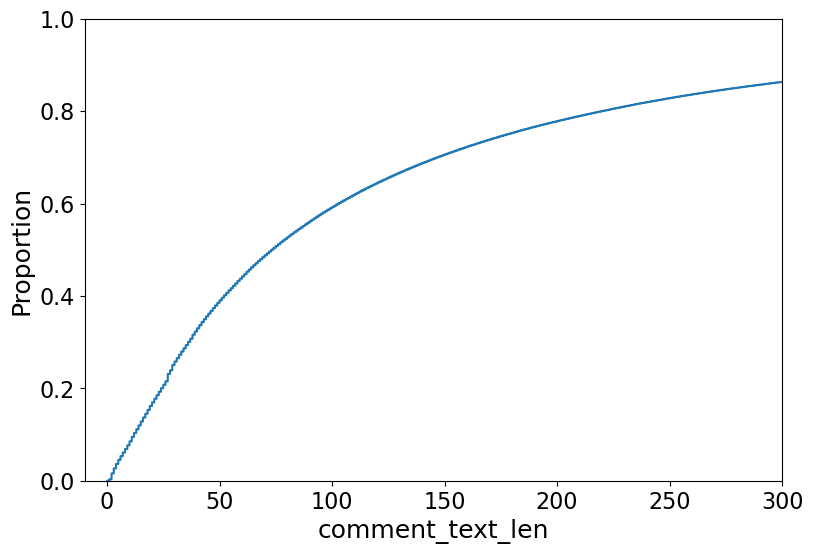

In [9]:
ax = sns.ecdfplot(
    data=d_dfs['df_comments_meta'],
    x='comment_text_len',
)
ax.set_xlim(-10, 300)

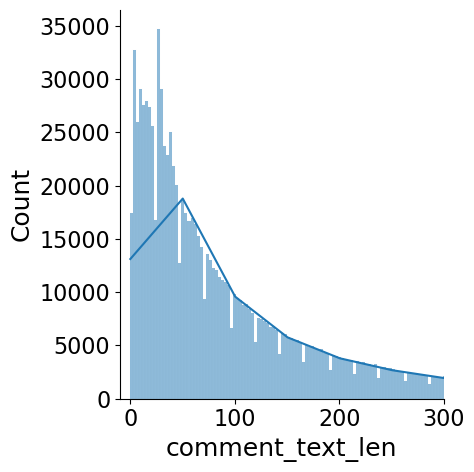

In [10]:
g = sns.displot(
    data=d_dfs['df_comments_meta'],
    x='comment_text_len',
    kde=True,
)
g.set(xlim=(-10, 300))

## How many words do we usually see in comments with text-len 10 or 11?

In [11]:
style_df_numeric(
    d_dfs['df_comments_meta']
    [d_dfs['df_comments_meta']['comment_text_len'] == 10]
    [['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"9,575.00","9,575"
mean,10.00,2
std,0.00,1
min,10.00,0
25%,10.00,1
50%,10.00,2
75%,10.00,2
max,10.00,5


In [12]:
style_df_numeric(
    d_dfs['df_comments_meta']
    [d_dfs['df_comments_meta']['comment_text_len'] == 11]
    [['comment_text_len', 'comment_text_word_count']].describe()
)

,comment_text_len,comment_text_word_count
count,"10,701.00","10,701"
mean,11.00,2
std,0.00,1
min,11.00,0
25%,11.00,2
50%,11.00,2
75%,11.00,2
max,11.00,6


# Job as function (old/legacy)

```python
df_posts_agg, df_subs_agg = aggregate_embeddings_mlflow(
    posts_uuid='db7a4d8aff04420eb4229d6499055e04',
    posts_folder='df_vect_posts',
    col_text_post_word_count='text_word_count',
    col_post_id='post_id',

    comments_uuid='db7a4d8aff04420eb4229d6499055e04',
    comments_folder='df_vect_comments',
    col_comment_id='comment_id',
    col_text_comment_word_count='comment_text_word_count',
    min_text_len_comment=None,

    subreddit_desc_uuid='db7a4d8aff04420eb4229d6499055e04',
    subreddit_desc_folder='df_vect_vect_subreddits_description',
    col_subreddit_id='subreddit_id',

    mlflow_experiment='use_multilingual_v1_aggregates_test',
    run_name='test_base',
    mlflow_tracking_uri='sqlite',

    n_sample_posts=1000,
    n_sample_comments=5000,
)

```

In [ ]:
LEGACY

## Get most similar subs

In [254]:
df_topics_new = value_counts_and_pcts(
    df_subs['new_topic_and_rating'],
    top_n=None,
    add_col_prefix=False,
    count_type='subreddits',
    return_df=True
)
style_df_numeric(df_topics_new, l_bar_simple=df_topics_new.columns)

,subreddits_count,percent_of_subreddits,cumulative_percent_of_subreddits
over18_nsfw,51,26.02%,26.02%
gaming,29,14.80%,40.82%
uncategorized,22,11.22%,52.04%
reddit institutions,21,10.71%,62.76%
food and drink,18,9.18%,71.94%
sports,13,6.63%,78.57%
internet culture and memes,12,6.12%,84.69%
"culture, entertainment, music",11,5.61%,90.31%
place/culture,8,4.08%,94.39%
podcasts and streamers,5,2.55%,96.94%


In [223]:
from subclu.models.model_utils import get_most_similar_items

In [295]:
l_col_most_similar = [
    'subreddit_name',
    'new_topic_and_rating',
    'rating',
    'over_18',
    'whitelist_status',
    'users_l28',
    'subscribers',
    'posts_l28',
    'comments_l28',
    'subreddit_title',
    'subreddit_public_description',
]
l_col_most_similar_no_txt = [
    'subreddit_name',
    'new_topic_and_rating',
    'rating',
    'over_18',
    'whitelist_status',
    'users_l28',
    'subscribers',
    'posts_l28',
    'comments_l28',
]


In [297]:
top_subs_per_category = 1

for topic_ in df_topics_new[df_topics_new['subreddits_count'] > 25].index:
    largest_communities = (
        df_subs
        [df_subs['new_topic_and_rating'] == topic_]
        .sort_values(by=['users_l28'], ascending=False)
#         ['subreddit_name'].values
    )
    print(f"\n\nTopic: {topic_}\n==="
          f'\nLargest communities:')
    display(style_df_numeric(largest_communities[l_col_most_similar_no_txt].head()))
    
    for n_ in range(top_subs_per_category):
#         print(f"\n{largest_communities['subreddit_name'].values[n_]}\n---")
        display(
            style_df_numeric(
                get_most_similar_items(
                    largest_communities['subreddit_name'].values[n_],
                    df_sim_sub, df_subs, top_n=10,
                    col_meta_merge='subreddit_name',
                    meta_cols_to_merge=l_col_most_similar,
                ),
                int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
            )
        )




Topic: over18_nsfw
===
Largest communities:


,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28
7,nicoledobrikov,over18_nsfw,None,t,None,"840,306","129,046",10,"3,004"
8,germansgonewild,over18_nsfw,x,t,no_ads,"350,954","124,164","2,216","18,030"
15,elisaalineunconsored,over18_nsfw,None,t,None,"275,124","72,091",467,996
40,elisaaline1,over18_nsfw,None,t,no_ads,"191,354","19,617",27,"2,806"
92,katjakrasavicenudes,over18_nsfw,None,t,None,"188,112","5,763","7,165","5,392"


,nicoledobrikov,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,nicoledobrikov,over18_nsfw,None,t,None,"840,306","129,046",10,"3,004",NicoleDobrikov,"Ein Subreddit für Nicole Dobrikov, Influencerin aus Instagram und TikTok"
1,0.79,nicoledobri,uncategorized,None,None,None,"39,884","1,840",123,100,NicoleDobri,Nicole Dobrikov Onlyfans
2,0.74,nicoledobrikov1,uncategorized,None,f,no_ads,"457,343","21,468",36,"11,505",Nicole Dobrikov Fans,None
3,0.73,papaplatte,podcasts and streamers,pg,None,all_ads,"34,986","73,998",333,749,Papaplatte Subreddit,"Hier kannst du alles bezüglich Papaplatte posten, egal ob Memes, Fanarts oder Vorschläge für den Stream."
4,0.72,germancelebritiesfap2,over18_nsfw,None,t,None,"146,634","10,535",420,524,germanCelebritiesFAP2,"Das Sub für alles Schöne aus Deutschland. Postet hier gerne Bilder und Videos von deutschen Promis. - Bitte im Titel den Namen aufnehmen - Keine Bedingungen / DM Aufforderungen - Kein SPAM, nur on-topic - Keine Beleidigungen oder abfällige Bemerkungen und seit nett zueinander"
5,0.72,kellymissesvlog,over18_nsfw,nc17,None,no_ads,"46,952","19,986",72,127,"Bilder, Screenshots und Clips rund um die Youtuberin Kelly Missesvlog","Bilder, screenshots und Clips rund um die Youtuberin Kelly Missesvlog. Folgt ihr auf Social Media: - https://www.youtube.com/user/MissesVlog - https://www.twitch.tv/kellylein/videos - http://instagram.com/kel - http://twitter.com/MissesVlog"
6,0.71,germancelebnew,over18_nsfw,None,t,None,"45,586","7,775",111,122,GermanCelebNew,"Wir möchten hier nur deutsche weibliche Prominente. Anfragen zum Bildertausch, RP, wichsen, cumtributes, discord links irgendwas mit Klassenkameraden oder fakes werden hier nicht gestattet und führen sofort zum Bann. Keine Werbung für andere subreddits ohne Absprache mit einem mod Das posten von Minderjährigen ist strengstens verboten. Bitte achtet auf eure Wortwahl Ansonsten ist hier jeglicher Austausch gestattet und gewünscht. Keine Beleidigungen den promis oder Usern gegenüber."
7,0.69,nicoledobrikovofs,nan,nan,nan,nan,-,-,-,-,nan,nan
8,0.69,loredana,nan,nan,nan,nan,-,-,-,-,nan,nan
9,0.68,influencernsfw,uncategorized,None,f,None,"31,445","5,846","1,226",56,InfluencerNSFW,"Willkommen bei InfluencerNSFW, einem Subreddit für Bilder von deutschen Influencerinnen und Promis!"




Topic: gaming
===
Largest communities:


,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28
132,annode,gaming,None,None,all_ads,"6,774",453,65,235
125,nintendode,gaming,None,f,None,"6,591",836,42,82
141,pcbaumeister,gaming,None,None,all_ads,"2,649",218,54,290
143,aoede,gaming,None,None,all_ads,"2,460",160,46,90
154,totalwarde,gaming,None,None,all_ads,"1,013",41,27,10


,annode,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,annode,gaming,None,None,all_ads,"6,774",453,65,235,AnnoDE,Willkommen auf dem deutschsprachigen Ort auf Reddit für alles rund um die Anno-Serie!
1,0.77,heutelernteich,reddit institutions,None,None,all_ads,"3,872","1,501",73,61,Heute Lernte Ich,Du hast heute etwas Interessantes gelernt? Teile es mit der Reddit Community! Oder folge dem Subreddit um neue Dinge zu lernen.
2,0.75,geschichtsmaimais,internet culture and memes,pg,None,all_ads,"13,831","14,781",155,"1,397",Ein Unter für Geschichtsmaimais,"Geschichte ist toll, Maimais auch warum nicht beides kombinieren? Hier könnt ihr Geschichtsmaimais pfostieren und sie mit Freunden der Geschichte teilen. Bitte Pfostiert aber nur auf Deutsch für Angelsachsen ist der r/historymemes Unter da."
3,0.74,rbtv_cj,internet culture and memes,pg,f,all_ads,"36,180","6,777",269,"9,159",Rocket Beans Circlejerk,
4,0.74,600euro,internet culture and memes,r,None,some_ads,"74,326","31,334",541,"13,335",Offizielle Außenstelle der deutsch GmbH kolonie der USA.,"Hier passen Geschichten von sozialen Medien hinein, welche zwar behaupten, wahr zu sein, aber einfach sehr schlecht und unglaubwürdig sind. Gute Beispiele hierfür sind schlechte Hetzposts gegen Asylsuchende, oder Kettenbriefe."
5,0.73,de_iama,reddit institutions,pg,None,all_ads,"66,694","385,199",65,"4,194",Triff interessante Leute und frage ihnen Löcher in den Bauch!,Die deutschsprachige Version von /r/IAMA
6,0.73,mauerstrassenwetten,internet culture and memes,r,None,some_ads,"124,140","96,746",705,"67,821",mauerstrassenwetten,Als hätte 4chan ein Bloomberg Terminal gefunden; Aber auf Deutsch! Für Anfragen per Mail: mods@mauerstrassenwetten.de
7,0.73,totalwarde,gaming,None,None,all_ads,"1,013",41,27,10,TotalWarDE,Die deutschsprachige Community auf Reddit für alles rund um die Total War-Reihe!
8,0.73,laesterschwestern,podcasts and streamers,pg,f,all_ads,"56,212","14,799",107,"1,208",Lästerschwestern Podcast,"Das Reddit rund um den Podcast Lästerschwestern. Hier diskutieren und lästern YouTuber Robin Blase & Journalistin Lisa Ludwig über YouTube, das Internet, Social Media und Influencer. Hauptsache lästern! Hier diskutiert Robin auch mit /u/robbubble. Ehemaliger Co-Host & Gründungsmitglied /u/David_BeHaind bleibt Ehrenmitglied und immer in unseren Herzen <3"
9,0.73,fragreddit,reddit institutions,pg,f,all_ads,"104,939","28,286",641,"11,745",Frag Reddit - auf Deutsch,None


### Add more meta columns for each sub

In [256]:
df_sub_agg2 = df_sub_agg2.merge(
    df_subs,
    how='left',
    on=l_keys_sub_only,
)

In [298]:
df_sub_agg2['new_topic_and_rating'] = df_sub_agg2['new_topic_and_rating'].fillna('uncategorized')

In [299]:
#  %%time

# fig = px.scatter_3d(
#     df_sub_agg,
#     x='tsne_0_mean', y='tsne_1_mean', z='tsne_2_mean',
#     color='subreddit_name'
# )
# fig.show()

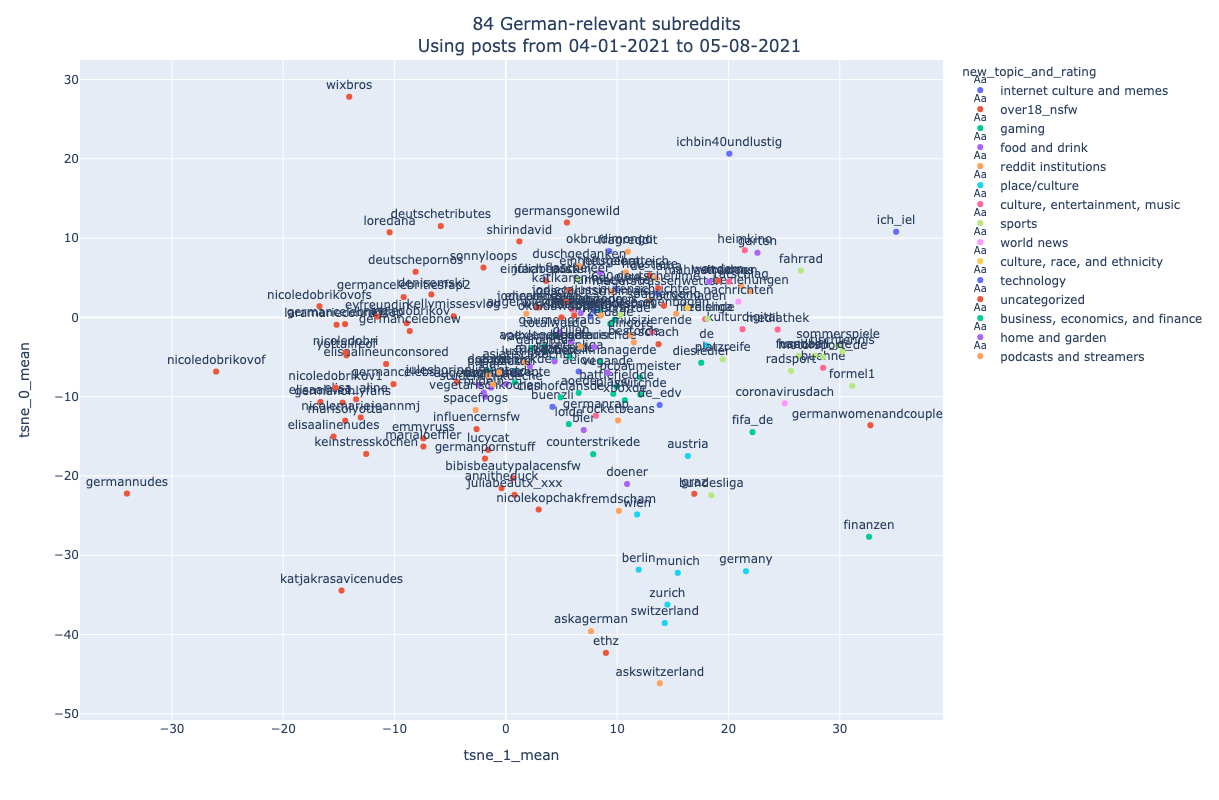

CPU times: user 104 ms, sys: 4.5 ms, total: 108 ms
Wall time: 105 ms


In [300]:
 %%time

fig = px.scatter(
    df_sub_agg2,
    y='tsne_0_mean', x='tsne_1_mean',
    color='new_topic_and_rating',
    text='subreddit_name',
)
fig.update_traces(textposition='top center')
fig.update_layout(
    title_text="84 German-relevant subreddits <br>Using posts from 04-01-2021 to 05-08-2021",
    title_x=0.5,
    width=1100,
    height=800,
    uniformtext_minsize=8, uniformtext_mode='hide',
)
fig.show()

In [319]:
# df_sim_sub.head()

In [320]:
style_df_numeric(
    get_most_similar_items(
        'fifa_de',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,fifa_de,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,fifa_de,gaming,None,None,all_ads,47,13,12,5,FIFA_DE,Das deutschsprachige FIFA-Subreddit für Fans der Fußball-Spielserie von EA Sports
1,0.63,battlefieldde,gaming,None,None,all_ads,351,459,31,20,BattlefieldDE,Das deutsche Subreddit rund um das beliebte Shooter-Franchise von EA und DICE und natürlich alle Neuigkeiten zu Battlefield 6
2,0.62,fussball,sports,None,None,all_ads,"5,479","1,182",258,471,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,Das deutschsprachige Subreddit rund um die schönste Nebensache der Welt!
3,0.58,footballmanagerde,gaming,None,None,all_ads,22,9,7,0,FootballManagerDE,Das Sub für alle FootballManager Fans!
4,0.56,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
5,0.56,radsport,sports,None,None,all_ads,649,116,121,90,Radsport auf Reddit.,"Die deutschsprachige Community für Radsport - von RTFs über Cyclocross und Mountainbikesport bis zu den UCI Klassikern. Tauscht Euch aus über Events, Training, Equipment und mehr."
6,0.54,platzreife,sports,None,None,all_ads,139,20,59,4,Platzreife,"Deutschsprachiges Clubhaus für alle Golfbegeisterten auf Reddit - ob mit oder ohne Platzreife. Tauscht Euch aus über Trainig, Equipment, Plätze, Tuniere und mehr."
7,0.54,xboxde,gaming,None,None,all_ads,396,27,22,18,Xbox auf Deutsch,Das deuschsprachige Subreddit für Xbox Enthusiasten!
8,0.52,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.
9,0.52,eurotruckde,gaming,None,None,all_ads,19,10,6,0,EuroTruckDE,Das Sub für alle Eurotruck Fans!


In [306]:
style_df_numeric(
    get_most_similar_items(
        'bier',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,bier,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,bier,food and drink,r,None,some_ads,"2,290","4,872",28,163,Bier,"r/Bier: The community for German, Dutch and Belgian beer lovers."
1,0.71,doener,food and drink,pg,None,all_ads,"30,745","20,623",33,333,/r/doener macht schöner,"Döner Kebab is one of the most famous dishes of the Turkish cuisine and is enjoying huge popularity in Germany and other european countries. Posts about similiar dishes from the Turkish, Greek or Arab cuisine are welcome."
2,0.69,buenzli,internet culture and memes,pg,None,all_ads,"26,435","41,849",278,"4,046",Will mer wüssed que nous sommes il migliore!,
3,0.68,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
4,0.68,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
5,0.66,germanrap,"culture, entertainment, music",r,None,some_ads,"58,657","17,606",513,"3,710",Das Deutschrap-Forum,"Für deutschen Rap und Rap aus Deutschland, sowie den umrahmenden Hip-Hop-Kontext."
6,0.61,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
7,0.61,graz,uncategorized,None,None,None,"6,844","7,835",107,"1,147",Verschiedenes aus Graz,Subreddit für die zweitgrößte Stadt Österreichs.
8,0.61,vegande,food and drink,pg,None,all_ads,"30,364","9,627",168,"2,811",Vegan auf Deutsch,"Informationen und Neuigkeiten über Veganismus in Deutschland, Österreich und der Schweiz."
9,0.60,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.


In [307]:
style_df_numeric(
    get_most_similar_items(
        'doener',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,doener,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,doener,food and drink,pg,None,all_ads,"30,745","20,623",33,333,/r/doener macht schöner,"Döner Kebab is one of the most famous dishes of the Turkish cuisine and is enjoying huge popularity in Germany and other european countries. Posts about similiar dishes from the Turkish, Greek or Arab cuisine are welcome."
1,0.72,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
2,0.71,bier,food and drink,r,None,some_ads,"2,290","4,872",28,163,Bier,"r/Bier: The community for German, Dutch and Belgian beer lovers."
3,0.68,berlin,place/culture,pg,f,all_ads,"192,402","118,917","1,141","18,886",Neues Aus Berlin,"The bilingual subreddit for everything relating to Berlin, capital city of Germany."
4,0.67,munich,place/culture,pg,None,all_ads,"35,498","43,887",301,"2,464",Subreddit für München,None
5,0.66,germanpornstuff,over18_nsfw,None,t,None,"51,912","23,786",175,283,Porn from Germany - Filthy as ever …,Teutonic Porn and Adult Cöntent
6,0.65,germany,place/culture,pg,f,all_ads,"388,455","286,701","1,992","22,197",Germany,English-language discussions and news relating to Germany and German culture.
7,0.65,zurich,place/culture,pg,None,no_ads,"16,415","20,145",102,"1,134",Zürich,Subreddit for the beautiful city and canton of Zurich
8,0.63,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
9,0.63,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."


In [308]:
style_df_numeric(
    get_most_similar_items(
        'wien',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,wien,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
1,0.86,berlin,place/culture,pg,f,all_ads,"192,402","118,917","1,141","18,886",Neues Aus Berlin,"The bilingual subreddit for everything relating to Berlin, capital city of Germany."
2,0.86,munich,place/culture,pg,None,all_ads,"35,498","43,887",301,"2,464",Subreddit für München,None
3,0.83,germany,place/culture,pg,f,all_ads,"388,455","286,701","1,992","22,197",Germany,English-language discussions and news relating to Germany and German culture.
4,0.82,austria,place/culture,pg,f,all_ads,"194,313","192,632","2,307","40,012",reddit Rot-Weiß-Rot,"Subreddit für Österreicher und Austrophile, alles mit Österreichbezug ist hier gern gesehen. Subbreddit for Austrians and Austrophiles, everything relevant to Austria is encouraged here."
5,0.81,zurich,place/culture,pg,None,no_ads,"16,415","20,145",102,"1,134",Zürich,Subreddit for the beautiful city and canton of Zurich
6,0.80,graz,uncategorized,None,None,None,"6,844","7,835",107,"1,147",Verschiedenes aus Graz,Subreddit für die zweitgrößte Stadt Österreichs.
7,0.80,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."
8,0.80,switzerland,place/culture,pg13,f,no_ads,"87,226","114,933",670,"10,459",Switzerland,All things Switzerland!
9,0.79,ethz,uncategorized,pg13,None,all_ads,"9,544","7,960",61,524,ETH Zurich,are you studying? no? then go study.


In [309]:
style_df_numeric(
    get_most_similar_items(
        'germanwomenandcouples',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,germanwomenandcouples,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,germanwomenandcouples,uncategorized,None,f,None,"34,265","9,098","1,567","1,855",germanwomenandcouples,"Frauen und Paare zeigt euch sexy! Erotik, Sex und Nacktheit für Deutschland ����, Österreich ���� und die Schweiz ���� German speakers are also allowed to post. Links von anderen Seiten sind nicht erlaubt!"
1,0.70,bibisbeautypalacensfw,over18_nsfw,None,t,None,"37,947","9,206","1,471",491,BibisBeautyPalaceNSFW,Eine Community zum Austausch und Teilen von Bildern der deutschen YouTuberin BibisBeautyPalace.
2,0.67,juliabeautx_xxx,over18_nsfw,None,t,None,"30,219","6,409","1,412",249,JuliaBeautx_XXX,Sub für die wunderbre Julia Beautx. Viel Spaß beim posten :)
3,0.66,annitheduck,over18_nsfw,None,t,None,"65,341","18,073","1,541",325,Fansub für AnniTheDuck.,"Fan-Subreddit für YouTuberin, Streamerin und Cosplayerin Anni The Duck. Subreddit for YouTuber, Streamer and Cosplayer Anni The Duck."
4,0.61,marialoeffler,over18_nsfw,None,t,None,"65,123","3,781","1,500",708,Marialoeffler,MariaLoeffler
5,0.58,germanpornstuff,over18_nsfw,None,t,None,"51,912","23,786",175,283,Porn from Germany - Filthy as ever …,Teutonic Porn and Adult Cöntent
6,0.58,katjakrasavicenudes,over18_nsfw,None,t,None,"188,112","5,763","7,165","5,392",KatjaKrasaviceNudes,ONLY THE BEST AND HOTTEST PICS OF THE BOSSBITCH❤️
7,0.57,wien,place/culture,None,None,all_ads,"43,445","41,171",435,"7,471",nachrichten über/aus/von wien,"A subreddit for inhabitants, citizens, visitors, tourists, expats and other people interested in the Austrian capital, Vienna. Ein subreddit für Bewohner, Bürger, Besucher, Touristen, Expatrioten und andere Leute die an Österreichs Hauptstadt Wien Interesse haben. -- About vienna: ""you can be as unfriendly as you want here, just never be impolite"""
8,0.55,askagerman,reddit institutions,pg,None,all_ads,"32,469","20,538",268,"7,112",For everything you've always wanted to know about Germany,"This is the subreddit for all questions regarding Germany, Germans and life in Germany."
9,0.55,elisaalineunconsored,over18_nsfw,None,t,None,"275,124","72,091",467,996,ElisaAlineUnconsored,alles dreht sich hier um Elisa Aline ohne Linkspams etc. ! ��


In [310]:
style_df_numeric(
    get_most_similar_items(
        'fifa_de',
        df_sim_sub, df_subs, top_n=10,
        col_meta_merge='subreddit_name',
        meta_cols_to_merge=l_col_most_similar,
    ),
    int_cols=['users_l28', 'subscribers', 'posts_l28', 'comments_l28']
)

,fifa_de,subreddit_name,new_topic_and_rating,rating,over_18,whitelist_status,users_l28,subscribers,posts_l28,comments_l28,subreddit_title,subreddit_public_description
0,1.00,fifa_de,gaming,None,None,all_ads,47,13,12,5,FIFA_DE,Das deutschsprachige FIFA-Subreddit für Fans der Fußball-Spielserie von EA Sports
1,0.63,battlefieldde,gaming,None,None,all_ads,351,459,31,20,BattlefieldDE,Das deutsche Subreddit rund um das beliebte Shooter-Franchise von EA und DICE und natürlich alle Neuigkeiten zu Battlefield 6
2,0.62,fussball,sports,None,None,all_ads,"5,479","1,182",258,471,/r/fussball - Das deutschsprachige subreddit rund ums Thema Fußball,Das deutschsprachige Subreddit rund um die schönste Nebensache der Welt!
3,0.58,footballmanagerde,gaming,None,None,all_ads,22,9,7,0,FootballManagerDE,Das Sub für alle FootballManager Fans!
4,0.56,bundesliga,sports,pg13,None,all_ads,"40,530","313,421",155,"1,885",German Bundesliga: News & Highlights,"Bundesliga is Germany's top-tier football league. It was founded in 1963 and features clubs such as FC Bayern München, Borussia Dortmund, FC Schalke 04, Bayer 04 Leverkusen, and Hertha BSC ."
5,0.56,radsport,sports,None,None,all_ads,649,116,121,90,Radsport auf Reddit.,"Die deutschsprachige Community für Radsport - von RTFs über Cyclocross und Mountainbikesport bis zu den UCI Klassikern. Tauscht Euch aus über Events, Training, Equipment und mehr."
6,0.54,platzreife,sports,None,None,all_ads,139,20,59,4,Platzreife,"Deutschsprachiges Clubhaus für alle Golfbegeisterten auf Reddit - ob mit oder ohne Platzreife. Tauscht Euch aus über Trainig, Equipment, Plätze, Tuniere und mehr."
7,0.54,xboxde,gaming,None,None,all_ads,396,27,22,18,Xbox auf Deutsch,Das deuschsprachige Subreddit für Xbox Enthusiasten!
8,0.52,rocketbeans,podcasts and streamers,pg,None,all_ads,"49,137","78,126",111,"3,192",Alles was die Böhnchen betrifft..,Willkommen bei /r/rocketbeans! Dies ist das Subreddit rund um die Rocket Beans und ihren YouTube Content.
9,0.52,eurotruckde,gaming,None,None,all_ads,19,10,6,0,EuroTruckDE,Das Sub für alle Eurotruck Fans!


# Upload saved files to GCS

In [69]:
path_this_ft_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-09_19')

In [78]:
path_prev_ft_model

PosixPath('/home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17')

In [71]:
[f.name for f in path_this_ft_model.glob('*') if f.is_file()]

[]

In [72]:
[f.name for f in path_prev_ft_model.glob('*') if f.is_file()]

['df_vectorized_posts_svd_tsne-init_pca-perplexity_30-rand_state_42-ids_index-111669_by_2.parquet',
 'df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-28_by_2.parquet',
 'df_vectorized_posts_combined_with_comments-post_ids_index-111669_by_300.parquet',
 'df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-167_by_2.parquet',
 'df_vectorized_posts_svd-ids_index-111669_by_50.parquet']

In [80]:
bucket_upload_dir = f'gs://i18n-subreddit-clustering/data/models/fse/{path_this_ft_model.name}'
bucket_upload_dir

'gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-09_19'

In [81]:
bucket_upload_dir_prev = f'gs://i18n-subreddit-clustering/data/models/fse/{path_prev_ft_model.name}'
bucket_upload_dir_prev

'gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-07_17'

In [82]:
!echo $path_this_ft_model $bucket_upload_dir

/home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-09_19 gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-09_19


In [97]:
!echo $path_prev_ft_model $bucket_upload_dir_prev

/home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17 gs://i18n-subreddit-clustering/data/models/fse/manual_merge_2021-06-07_17


In [271]:
!gsutil -m cp -r $path_this_ft_model $bucket_upload_dir

Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd_tsne-init_pca-perplexity_30-rand_state_42-ids_index-111669_by_2.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-28_by_2.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd_tsne-agg_to_subreddit-ids_index-167_by_2.parquet [Content-Type=application/octet-stream]...
Copying file:///home/jupyter/subreddit_clustering_i18n/data/models/fse/manual_merge_2021-06-07_17/df_vectorized_posts_svd-ids_index-111669_by_50.parquet [Content-Type=application/octet-stream]...
- [4/4 files][ 33.3 MiB/ 33.3 MiB] 100% Done                                    
Operation completed over 4 objects/33.3 MiB.               

In [99]:
# !gsutil -m cp -r $path_prev_ft_model $bucket_upload_dir_prev

# Subreddit level from the start
Instead of rolling up from post-level, what does a sub look like when we treat all posts as part of the same "document" from the start?
- This would be the doc2vec approach that Simon already uses for ads similarity subreddits.

# Other ways to get subreddit-level vectors


- Get mean of 300-len vectors AND then convert to t-SNE
- Merge posts for all subs and train a new uSIF model on the text
  - Downside: it'll take much longer to train
  - Upside: we'll be able to use `similarity` functions.
  
from tutorial:
> After training the sentence embedding we can access each individual embedding by its index or the complete embedding matrix. The syntax is as close to Gensims syntax as possible for easy usage...
> 
> The corresponding Sentencevectors (sv) class provides quite a few functions to work with the resulting sentence embeddings. For example, you can use similarity, distance, most_similar, similar_by_word, similar_by_sentence, or similar_by_vector.